In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate
from tensorflow.keras.models import Model, Sequential
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_deblender, load_alpha, denorm, delta_min
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
import generator_deblender

In [4]:
from generator_deblender import BatchGenerator_test, BatchGenerator

In [5]:
from importlib import reload

In [6]:
reload(generator_deblender)

<module 'generator_deblender' from '/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Deblender/generator_deblender.py'>

In [7]:
from generator_deblender import BatchGenerator_test, BatchGenerator

# Function to import dense VAE

In [10]:
# Parameters
batch_size = 100
original_dim = 64*64*6

In [11]:
alpha = K.variable(1e-4)
deblender, encoder, Dkl = load_deblender('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/', '/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v8/mse/', 6, folder = True)
K.set_value(alpha, load_alpha('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/'))

def deblender_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=[1,2,3]))#original_dim*
    kl_loss = K.get_value(alpha) * Dkl
    return xent_loss + K.mean(kl_loss)

deblender.compile('adam', loss=deblender_loss, metrics=['mse'])

## Stamp size for plots

In [12]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Load test list

In [13]:
r= np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_redshift_v5.npy')

In [14]:
mag = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_magnitude_v5.npy')

# Function to compute the delta_r for each blended image

In [15]:
def delta_r_min(shift_path):
    shift =np.load(shift_path)
    
    #Reshape the list of shifts so that it is easily usable
    shifts = np.zeros((len(shift),4,2))
    for i in range (len(shift)):
        for j in range (len(shift[i])):
            shifts[i][j] = shift[i][j]
    #print(shifts)    
    # set lists
    deltas_r= np.zeros((len(shift),4))
    delta_r= np.zeros((len(shift)))
    
    # compute the delta r for each couple of galaxies
    for i in range (4):
        deltas_r[:,i] = np.sqrt(np.square(shifts[:,i,0])+np.square(shifts[:,i,1]))

    # Take the min of the non zero delta r
    for j in range (len(shifts)):
        # If all the deta_r are equals to 0 (there is only on galaxy on the image) then write 0
        if (deltas_r[j,:].any() == 0):
            delta_r[j] = 0
        else:
            x = np.where(deltas_r[j] == 0)[0]
            deltas = np.delete(deltas_r[j],x)
            delta_r[j] = np.min(deltas)
    
    return delta_r

In [16]:
shift = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_shift_v5.npy')

In [15]:
delta_r = delta_r_min('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_shift_v5.npy')

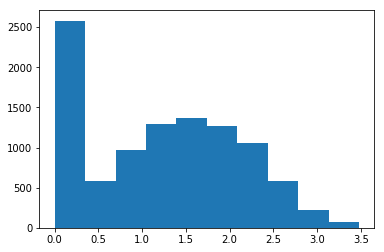

In [16]:
_ = plt.hist(delta_r)

In [33]:
mag.shape, mag[0], mag[2]

((100,), [26.86235248636027], [26.451210934857542])

In [34]:
for i in range (20):
    print(mag[i])

[26.86235248636027]
[29.46929983406686, 26.853952761768706]
[26.451210934857542]
[26.17212952653915, 26.996009960302455, 28.40811503278026, 22.486276118273437]
[27.921785029907713, 25.891599211863806, 27.830088248830357, 27.45482407108213]
[25.05721864654823]
[27.401023712313897, 27.999226590968995, 26.574241195727204]
[25.905064868502777, 27.920750650140523, 24.448080803067718]
[26.12325266422262, 24.520647435904095]
[23.520920147736625, 25.027966963761894, 27.52233606627347]
[27.616134231206587]
[27.96065017382977, 26.550931486806256]
[25.363465415789165, 28.031378544592446, 27.70946531066444, 27.157557593862833]
[28.525969056228277, 28.24438714425273, 26.394978556958627]
[27.785910570583564, 26.94012212969869]
[22.57046555002716]
[26.994335462113916, 29.33574740442492, 28.511801894045135]
[25.32277277700458, 26.648062214535457, 27.322300484775667]
[26.77432894968299, 27.558666582412815]
[27.38339818320135, 24.42807216411059]


In [115]:
mag.shape, len(mag[0]), shift.shape, len(shift[0])

((10000,), 4, (10000,), 3)

In [67]:
#Reshape the list of shifts so that it is easily usable
shifts = np.zeros((len(shift),3,2))
mags = np.zeros((len(shift),4))

for i in range (len(shift)):
    for j in range (len(shift[i])):
        shifts[i][j] = shift[i][j]
    for j in range (len(mag[i])):
        mags[i][j] = mag[i][j]

# set lists
deltas_r= np.zeros((len(shift),3))
delta_r= np.zeros((len(shift)))

deltas_mag= np.zeros((len(shift),3))
delta_mag = np.zeros((len(shift)))

# compute the delta r for each couple of galaxies
for i in range (3):
    deltas_r[:,i] = np.sqrt(np.square(shifts[:,i,0])+np.square(shifts[:,i,1]))

#for i in range (3):
    print(str(i))
    deltas_mag[:,i] = mags[:,i+1] - mags[:,0]
    print(deltas_r[:,i])
    print(deltas_mag[:,i])


# Take the min of the non zero delta r
c = 0
for j in range (len(shifts)):
    print('image : '+str(j))
    # If all the deta_r are equals to 0 (there is only on galaxy on the image) then write 0
    if (deltas_r[j,:].any() == 0):
        delta_r[j] = 0
        delta_mag[j] = 0
        print('par ici')
        c+=1
    else:
        x = np.where(deltas_r[j] == 0)[0]
        deltas = np.delete(deltas_r[j],x)
        delta_r[j] = np.min(deltas)
        y = np.where(deltas == np.min(deltas))[0]
        print(np.min(deltas), deltas)
        delta_mag[j] = deltas_mag[j,y]
        print(y, deltas_mag[j,y], deltas_mag[j])

0
[2.01533873 2.51794832 2.64705327 ... 2.85864182 1.64064312 2.53862113]
[-1.86509617 -1.23999    -1.11882075 ...  0.38250373  2.08866525
  2.61880822]
1
[1.54555736 2.47641545 2.20088023 ... 1.69703902 1.24096086 2.11721902]
[-1.17924099  0.39394949  0.58261771 ...  0.29480849  0.09366452
  0.09046548]
2
[2.69790255 2.09594188 0.         ... 2.17069016 0.         0.        ]
[ -0.8321597    0.21007398 -27.6426011  ...   0.45828811 -26.18426574
 -24.79760455]
image : 0
1.5455573553144586 [2.01533873 1.54555736 2.69790255]
[1] [-1.17924099] [-1.86509617 -1.17924099 -0.8321597 ]
image : 1
2.095941884696766 [2.51794832 2.47641545 2.09594188]
[2] [0.21007398] [-1.23999     0.39394949  0.21007398]
image : 2
2.2008802339828653 [2.64705327 2.20088023]
[1] [0.58261771] [ -1.11882075   0.58261771 -27.6426011 ]
image : 3
1.7803105750551262 [1.78031058 2.32129635]
[0] [0.86210458] [  0.86210458  -0.79163615 -26.68395972]
image : 4
1.7660790191804219 [1.78566997 2.89784296 1.76607902]
[2] [-1.195

image : 216
1.7963780829692813 [1.79637808 2.29353247 2.7582411 ]
[0] [0.08110705] [ 0.08110705 -0.63008224 -1.90541785]
image : 217
par ici
image : 218
2.0976965618396286 [2.09769656]
[0] [-0.89438548] [ -0.89438548 -27.80157513 -27.80157513]
image : 219
1.432522363166651 [1.43252236]
[0] [0.66796185] [  0.66796185 -27.12255719 -27.12255719]
image : 220
par ici
image : 221
2.4573252228007387 [2.45732522]
[0] [-1.56058337] [ -1.56058337 -28.45554723 -28.45554723]
image : 222
0.6837886757688356 [0.68378868 1.69490474]
[0] [-0.89271187] [ -0.89271187  -0.32797017 -27.80655663]
image : 223
1.0457971092309528 [1.04579711 2.43359361]
[0] [0.28084236] [  0.28084236  -1.49332079 -27.10491763]
image : 224
2.4741126924175068 [2.47411269]
[0] [-1.17939763] [ -1.17939763 -28.59067718 -28.59067718]
image : 225
2.0165543687196346 [2.61230143 2.16962382 2.01655437]
[2] [3.16466914] [2.87737245 1.39563219 3.16466914]
image : 226
2.058981654305786 [2.56877223 2.05898165 2.85074197]
[1] [-1.92055] [-1.

image : 416
2.5384227651940057 [2.53842277 3.02894807]
[0] [-3.02498412] [ -3.02498412   0.4501346  -27.15032258]
image : 417
0.8620514402386811 [0.86205144 1.20201542 2.19348009]
[0] [-2.44375577] [-2.44375577 -0.845055    0.53227299]
image : 418
1.6375509034024704 [1.6375509]
[0] [-1.56226552] [ -1.56226552 -27.67890284 -27.67890284]
image : 419
2.2257427778581746 [2.3126778  2.22574278]
[1] [2.95678175] [  1.84370199   2.95678175 -24.96854504]
image : 420
0.632289490762208 [0.63228949]
[0] [0.16462508] [  0.16462508 -27.34397342 -27.34397342]
image : 421
0.3895036056460043 [0.38950361 2.62813984]
[0] [1.41912145] [  1.41912145   0.63690654 -25.94890327]
image : 422
1.7093878473579078 [1.70938785]
[0] [-2.37238192] [ -2.37238192 -28.53430307 -28.53430307]
image : 423
par ici
image : 424
0.2567345328831693 [0.25673453]
[0] [3.98065134] [  3.98065134 -23.78878901 -23.78878901]
image : 425
2.12929574403721 [2.12929574 2.47473844]
[0] [2.87956412] [  2.87956412   1.91844462 -26.52424921]

[1] [0.23682484] [  1.72935296   0.23682484 -25.84317485]
image : 606
par ici
image : 607
1.3552826729239271 [1.35528267 2.80605314]
[0] [-0.8531821] [ -0.8531821    1.75201954 -25.2818733 ]
image : 608
1.1291753593486447 [1.12917536 2.17744455 2.47322778]
[0] [0.29076503] [0.29076503 0.5062061  0.22006196]
image : 609
par ici
image : 610
1.9332583684287137 [1.93325837 2.18484207]
[0] [0.62053974] [  0.62053974   1.66055651 -26.3402653 ]
image : 611
2.265599490876112 [2.36026545 2.26559949]
[1] [1.33588832] [  0.60137138   1.33588832 -25.74871709]
image : 612
0.9677756077892372 [0.96777561 1.01986611]
[0] [2.113012] [  2.113012     1.17236603 -25.55889385]
image : 613
2.3211164898509073 [3.10641726 2.32111649]
[1] [-1.02240172] [  1.81964079  -1.02240172 -26.2254849 ]
image : 614
1.0286624681149357 [1.02866247 2.7095471 ]
[0] [0.41398892] [  0.41398892  -2.75950678 -27.50706412]
image : 615
par ici
image : 616
2.607498554946908 [2.60749855]
[0] [-1.74643708] [ -1.74643708 -27.87590759 

par ici
image : 743
2.399388235245628 [2.39938824]
[0] [1.30181585] [  1.30181585 -27.055327   -27.055327  ]
image : 744
1.4280260557919557 [1.42802606]
[0] [1.95152291] [  1.95152291 -25.86658994 -25.86658994]
image : 745
1.839215455517449 [1.83921546]
[0] [-3.55497933] [ -3.55497933 -27.38121101 -27.38121101]
image : 746
par ici
image : 747
2.854331762675099 [2.85433176]
[0] [-0.78372018] [ -0.78372018 -27.53587612 -27.53587612]
image : 748
1.700546684448197 [1.70054668]
[0] [1.21492295] [  1.21492295 -26.68839814 -26.68839814]
image : 749
1.0166633329229737 [1.01666333 1.18990697 2.47588283]
[0] [1.26870144] [ 1.26870144  0.33039435 -0.50402456]
image : 750
2.382349863964628 [2.38234986 2.51970698]
[0] [0.08395472] [  0.08395472  -1.08240272 -27.59827439]
image : 751
1.0557281210122078 [2.10425345 1.3813772  1.05572812]
[2] [-1.07039694] [ 0.59941974  0.30542555 -1.07039694]
image : 752
1.122487230393504 [1.12248723]
[0] [-3.34280689] [ -3.34280689 -28.1642835  -28.1642835 ]
image :

[0] [-0.16939966] [ -0.16939966 -28.27633039 -28.27633039]
image : 908
2.227825222114355 [2.22782522]
[0] [-1.19230491] [ -1.19230491 -26.8986022  -26.8986022 ]
image : 909
par ici
image : 910
par ici
image : 911
1.6323627087958958 [2.08548854 1.63236271 3.15986533]
[1] [0.61527507] [ 0.08201943  0.61527507 -0.38923802]
image : 912
1.8020990974293989 [1.8020991]
[0] [-2.63349407] [ -2.63349407 -27.90096401 -27.90096401]
image : 913
2.197636165960315 [2.19763617]
[0] [1.48585486] [  1.48585486 -25.75881795 -25.75881795]
image : 914
1.5359090629093866 [1.53590906 2.27823624]
[0] [0.2320303] [  0.2320303   -1.09494302 -27.24269601]
image : 915
1.142455123435287 [1.82190832 1.14245512]
[1] [1.46943456] [  3.26317218   1.46943456 -25.17484228]
image : 916
1.078348433313846 [2.56107337 2.71608699 1.07834843]
[2] [0.93958194] [1.91358425 0.8582027  0.93958194]
image : 917
2.0123592216378166 [2.01235922]
[0] [1.01964021] [  1.01964021 -26.46688697 -26.46688697]
image : 918
par ici
image : 919


[0] [2.86351668] [  2.86351668 -26.53513962 -26.53513962]
image : 1126
par ici
image : 1127
2.7260609511872103 [2.72606095]
[0] [0.61382696] [  0.61382696 -27.34252743 -27.34252743]
image : 1128
2.001926261142551 [3.44465107 2.00192626]
[1] [0.5988718] [ -0.63147867   0.5988718  -27.61383592]
image : 1129
0.8510523903841732 [0.85105239 1.9373291 ]
[0] [-1.21471007] [ -1.21471007   1.45808734 -25.96669363]
image : 1130
1.7644971170057606 [2.23277013 1.76449712]
[1] [-0.02077147] [ 1.22530176e+00 -2.07714747e-02 -2.74619410e+01]
image : 1131
par ici
image : 1132
par ici
image : 1133
1.3824100990352746 [1.3824101]
[0] [-1.90836794] [ -1.90836794 -28.3015307  -28.3015307 ]
image : 1134
1.543933396552512 [1.55254056 1.5439334  2.39755402]
[1] [-0.49565776] [ 0.06608125 -0.49565776 -2.40284093]
image : 1135
0.5828716228629871 [0.58287162 1.96665952 1.09241556]
[0] [1.00176395] [ 1.00176395  1.96198374 -4.0835633 ]
image : 1136
par ici
image : 1137
1.071672503128649 [2.88622214 2.96703591 1.0

[0] [-0.86611842] [ -0.86611842 -28.1698144  -28.1698144 ]
image : 1328
1.1713831384093927 [3.08718239 1.17138314 2.40785368]
[1] [0.63012476] [-0.10679216  0.63012476 -3.79325348]
image : 1329
par ici
image : 1330
1.8893903010540074 [1.97926957 1.8893903 ]
[1] [0.94805352] [ -0.36213625   0.94805352 -26.36583039]
image : 1331
2.308931877970513 [2.34235263 2.30893188 2.97255506]
[1] [3.66499542] [3.21090511 3.66499542 3.09951957]
image : 1332
2.110140321694562 [2.11014032]
[0] [0.30504336] [  0.30504336 -26.48857241 -26.48857241]
image : 1333
par ici
image : 1334
2.215734970360178 [2.21573497 2.3058625 ]
[0] [0.12554374] [  0.12554374   0.23143838 -27.4551759 ]
image : 1335
0.2720935962490541 [0.2720936  1.8992796  2.97283532]
[0] [-0.31122001] [-0.31122001 -1.70577288  0.69122141]
image : 1336
0.5955520752012025 [0.59555208 1.79729809]
[0] [1.30550327] [  1.30550327   1.61253377 -26.12439589]
image : 1337
0.9249670017040835 [1.18083869 3.08571024 0.924967  ]
[2] [0.19803462] [ 0.75463

[0] [0.35038097] [  0.35038097 -26.16523169 -26.16523169]
image : 1596
par ici
image : 1597
0.595115501228008 [2.31213977 0.5951155  2.38056856]
[1] [-0.95082028] [-1.14547177 -0.95082028 -2.81322179]
image : 1598
0.6823355799176672 [2.06959972 1.88500829 0.68233558]
[2] [-1.63742638] [ 0.45879603  0.62973469 -1.63742638]
image : 1599
par ici
image : 1600
1.7100456545977536 [1.97808712 1.71004565]
[1] [3.24474599] [  2.88761192   3.24474599 -24.65535786]
image : 1601
1.2223431986851991 [1.2223432  2.02278266]
[0] [-1.02291668] [ -1.02291668  -0.70805793 -27.71734937]
image : 1602
1.1739136178067366 [1.17391362]
[0] [0.57626969] [  0.57626969 -26.9753198  -26.9753198 ]
image : 1603
1.7134370362869427 [1.71343704 2.13057689]
[0] [0.11830244] [  0.11830244  -2.59095858 -27.60788048]
image : 1604
0.941853867166518 [1.47924781 0.94185387 2.81004249]
[1] [0.46678604] [-0.71744178  0.46678604  1.03309606]
image : 1605
1.4576349374740014 [2.23184262 2.85561306 1.45763494]
[2] [-3.88385981] [-0

image : 1804
par ici
image : 1805
2.7106460841856332 [2.71064608]
[0] [-3.10488711] [ -3.10488711 -27.72780484 -27.72780484]
image : 1806
0.3996274587671935 [1.98645806 0.39962746]
[1] [0.68210996] [ -0.26426811   0.68210996 -27.19020904]
image : 1807
par ici
image : 1808
0.4580186751980133 [0.45801868]
[0] [-0.68772913] [ -0.68772913 -28.1100673  -28.1100673 ]
image : 1809
par ici
image : 1810
1.4005959325911854 [2.45708397 2.57353374 1.40059593]
[2] [4.8931255] [5.5890521  6.87148183 4.8931255 ]
image : 1811
2.765744602002622 [2.7657446]
[0] [-0.71738482] [ -0.71738482 -26.90844241 -26.90844241]
image : 1812
1.2923026012748298 [2.21426868 1.2923026 ]
[1] [-0.45582785] [  1.98340446  -0.45582785 -27.43430312]
image : 1813
par ici
image : 1814
1.0581056522711738 [1.05810565 1.41331276]
[0] [-3.01881069] [ -3.01881069  -1.64358562 -27.85765412]
image : 1815
1.8417610399457127 [1.84176104 2.56060855 1.99182763]
[0] [4.21729468] [4.21729468 4.6887095  1.26437329]
image : 1816
par ici
imag

1.398488121044267 [2.39562494 2.33147369 1.39848812]
[2] [-2.05644594] [-1.01899699 -4.73438966 -2.05644594]
image : 2000
0.824107490850902 [0.82410749 1.33094837 1.585131  ]
[0] [-3.09793472] [-3.09793472 -0.53679612 -1.23739408]
image : 2001
par ici
image : 2002
1.0757186966413 [1.0757187  1.2172852  2.11350074]
[0] [-0.47366608] [-0.47366608 -2.13195464 -1.09228745]
image : 2003
1.6126777882377044 [1.75071339 1.61267779]
[1] [2.74308577] [  2.4214754    2.74308577 -25.47151328]
image : 2004
2.0844205274052268 [2.43688472 2.21684756 2.08442053]
[2] [0.07657825] [-1.76490388 -0.48962836  0.07657825]
image : 2005
1.9491490884398308 [2.46405822 1.94914909]
[1] [0.1551159] [  1.08799819   0.1551159  -26.09203438]
image : 2006
0.7203245570839569 [1.50655048 2.52959644 0.72032456]
[2] [-2.44398104] [-3.66469156 -1.13396677 -2.44398104]
image : 2007
par ici
image : 2008
1.2879842953188165 [1.92476653 1.2879843  2.31361168]
[1] [2.63498074] [2.29593374 2.63498074 1.16588462]
image : 2009
1.1

[0] [-1.38932079] [ -1.38932079   0.29107335 -27.75784909]
image : 2185
1.0039615732864868 [2.33057806 1.00396157]
[1] [-2.46056743] [ 8.88029618e-03 -2.46056743e+00 -2.77638531e+01]
image : 2186
2.2667634067160143 [2.37038212 2.26676341 2.64216314]
[1] [3.58990999] [-0.8126174   3.58990999 -0.28567766]
image : 2187
1.4721279016982773 [1.4721279  1.72038318]
[0] [2.01014292] [  2.01014292   2.33454652 -26.03442247]
image : 2188
par ici
image : 2189
1.2400383312107008 [1.24003833]
[0] [0.34210996] [  0.34210996 -26.34707093 -26.34707093]
image : 2190
1.1712976758121336 [1.17129768]
[0] [1.15696812] [  1.15696812 -26.78077273 -26.78077273]
image : 2191
par ici
image : 2192
0.6965378408340785 [1.95612676 0.69653784]
[1] [0.9639266] [  1.42929571   0.9639266  -26.24549856]
image : 2193
1.9671298954841008 [2.54305243 1.9671299 ]
[1] [1.61640954] [ -3.61676706   1.61640954 -26.22755291]
image : 2194
1.9818186350344564 [2.24492196 1.98181864]
[1] [-2.89548078] [ -1.36604998  -2.89548078 -27.2

[1] [-2.49393121] [  0.13590812  -2.49393121 -27.6206339 ]
image : 2388
par ici
image : 2389
1.5984102978903971 [1.5984103  1.93631574]
[0] [0.11834928] [  0.11834928  -0.48999331 -27.35754141]
image : 2390
par ici
image : 2391
1.6795287758561004 [2.66499669 1.67952878]
[1] [0.35895207] [ -0.8135531    0.35895207 -25.80897887]
image : 2392
2.3490816611456444 [2.34908166 3.03671206]
[0] [0.215941] [  0.215941     2.59539052 -24.78283196]
image : 2393
2.535705971552321 [2.53570597]
[0] [1.14655677] [  1.14655677 -26.15426409 -26.15426409]
image : 2394
par ici
image : 2395
par ici
image : 2396
0.596286590199879 [0.59628659]
[0] [-1.54293504] [ -1.54293504 -27.33567792 -27.33567792]
image : 2397
1.69209885479001 [1.69209885 2.73051545 2.11194375]
[0] [3.55305387] [3.55305387 4.12267158 4.92842241]
image : 2398
par ici
image : 2399
1.3910630062051486 [1.39106301]
[0] [-1.41891099] [ -1.41891099 -28.28116671 -28.28116671]
image : 2400
par ici
image : 2401
par ici
image : 2402
1.2575997507778

[0] [-1.17635108] [ -1.17635108 -27.92119019 -27.92119019]
image : 2593
2.459896868496996 [2.45989687]
[0] [-1.13043605] [ -1.13043605 -28.18489658 -28.18489658]
image : 2594
3.1058147147299833 [3.10581471]
[0] [1.38491305] [  1.38491305 -25.54668475 -25.54668475]
image : 2595
par ici
image : 2596
1.8079220306725015 [2.46709381 2.00087818 1.80792203]
[2] [-0.7233102] [ 0.11335868 -1.72927582 -0.7233102 ]
image : 2597
2.5502517544049574 [2.55025175]
[0] [-2.16685929] [ -2.16685929 -24.96088189 -24.96088189]
image : 2598
0.7719147414866722 [1.12537062 0.77191474 2.30179495]
[1] [0.31216427] [-1.06556347  0.31216427  1.25083077]
image : 2599
2.2707971749478753 [2.27079717]
[0] [-1.49262197] [ -1.49262197 -27.52238487 -27.52238487]
image : 2600
2.309377310355526 [2.8073859  2.30937731]
[1] [-4.88548876] [ -1.22854403  -4.88548876 -27.59702954]
image : 2601
0.8609974976933368 [0.8609975]
[0] [-0.73952687] [ -0.73952687 -27.71099982 -27.71099982]
image : 2602
par ici
image : 2603
1.058371095

2.230134794958667 [2.23013479]
[0] [-0.59781146] [ -0.59781146 -26.17344428 -26.17344428]
image : 2868
1.2581190049597806 [1.258119   1.36557657]
[0] [1.51921561] [  1.51921561   0.868351   -26.70836014]
image : 2869
1.8208319210798711 [1.82083192 2.17271502 2.34583503]
[0] [0.10392373] [0.10392373 0.41009778 0.1454239 ]
image : 2870
0.7031350615954616 [0.70313506 1.7173569  2.94905193]
[0] [0.3367768] [0.3367768  1.77456948 0.65115551]
image : 2871
0.9284185356202872 [2.25602781 3.4495858  0.92841854]
[2] [0.86882126] [0.22787086 0.74226693 0.86882126]
image : 2872
2.514045494719267 [2.51404549]
[0] [-0.29128726] [ -0.29128726 -27.22936593 -27.22936593]
image : 2873
1.3405064801524467 [1.34050648 1.38811008]
[0] [-2.23903513] [ -2.23903513  -0.92304242 -28.21523998]
image : 2874
1.4565547408879416 [1.74034444 1.45655474]
[1] [0.37918534] [  0.09316737   0.37918534 -26.78678335]
image : 2875
1.5279042630568935 [1.52790426 1.83496655]
[0] [-0.39880523] [ -0.39880523   1.29751528 -26.714

1.0974571191846807 [1.09745712 1.62495016]
[0] [2.91574243] [  2.91574243   2.33265846 -25.24199703]
image : 3083
par ici
image : 3084
1.7717640190659114 [1.83696849 1.77176402 2.66792276]
[1] [-0.55348719] [-1.31861612 -0.55348719 -0.93098545]
image : 3085
1.5556654329612047 [1.55566543]
[0] [-1.96995028] [ -1.96995028 -27.78362666 -27.78362666]
image : 3086
par ici
image : 3087
1.9062511603745345 [1.90625116]
[0] [-0.22724883] [ -0.22724883 -27.71324257 -27.71324257]
image : 3088
par ici
image : 3089
0.5349993489634511 [0.53499935 1.85804017]
[0] [0.70644878] [  0.70644878   0.31960662 -26.98637867]
image : 3090
1.1594544290241005 [1.15945443]
[0] [0.07798376] [  0.07798376 -27.18374488 -27.18374488]
image : 3091
1.8180809594773055 [1.90820825 1.81808096 2.35367863]
[1] [-2.69237047] [-1.30396836 -2.69237047 -3.01222041]
image : 3092
2.2477265604215453 [2.24772656 2.99369132]
[0] [0.65063105] [  0.65063105  -2.69279732 -26.96405353]
image : 3093
par ici
image : 3094
1.22846230716269 

par ici
image : 3383
0.8944369971251117 [2.12168917 2.82179241 0.894437  ]
[2] [1.0454076] [1.23990448 0.07454997 1.0454076 ]
image : 3384
par ici
image : 3385
par ici
image : 3386
1.7716746250612465 [1.77167463 2.25557822]
[0] [0.11030343] [  0.11030343  -0.0524346  -27.47189037]
image : 3387
2.0193746584596037 [2.01937466 2.79236131]
[0] [-0.61084138] [ -0.61084138  -6.5510275  -28.07592289]
image : 3388
2.2592748159040013 [2.25927482]
[0] [0.85310505] [  0.85310505 -26.74090754 -26.74090754]
image : 3389
2.5966155008196243 [2.79440815 2.5966155 ]
[1] [1.24622368] [  0.97083553   1.24622368 -26.21970672]
image : 3390
1.6532609912244483 [1.65326099 2.09861864 2.8397876 ]
[0] [-2.84362471] [-2.84362471 -3.73497615 -1.43314981]
image : 3391
1.915657920323675 [1.91565792]
[0] [1.34731787] [  1.34731787 -26.65541664 -26.65541664]
image : 3392
par ici
image : 3393
1.4375309809943253 [1.43753098 3.04997071 1.58792352]
[0] [0.00448529] [ 0.00448529 -1.36115801 -2.0998005 ]
image : 3394
1.018

2.3626078797510446 [2.36260788 2.5590566 ]
[0] [2.24128486] [  2.24128486   2.88708983 -25.37096128]
image : 3690
2.029720041601558 [2.02972004]
[0] [-3.46253995] [ -3.46253995 -27.84928643 -27.84928643]
image : 3691
2.042404585648825 [2.04240459]
[0] [0.78741926] [  0.78741926 -25.66771677 -25.66771677]
image : 3692
par ici
image : 3693
par ici
image : 3694
0.652641194563593 [0.65264119 1.38286687 1.99065578]
[0] [2.82751093] [2.82751093 4.04895315 4.35488201]
image : 3695
par ici
image : 3696
par ici
image : 3697
1.0663670666333311 [1.06636707 1.31795574 1.83366842]
[0] [-0.3714324] [-0.3714324  -0.82442444 -2.41228495]
image : 3698
1.4212928474922444 [1.42129285 2.98537988 3.01749441]
[0] [1.61872661] [ 1.61872661 -0.7214077  -1.32372681]
image : 3699
par ici
image : 3700
1.9615003417661594 [1.96150034 2.82793752]
[0] [0.0435579] [  0.0435579   -0.61622074 -27.79112879]
image : 3701
1.0110514059800435 [1.47106021 1.01105141 2.75645067]
[1] [-1.99405488] [-1.73663752 -1.99405488 -0.9

1.350395256655376 [1.35039526 2.42448934 1.7950149 ]
[0] [0.15255519] [ 0.15255519 -0.37894736 -0.1124023 ]
image : 3968
par ici
image : 3969
0.3262935899208063 [1.38860986 1.40517207 0.32629359]
[2] [-2.67401869] [-2.7244827  -3.03571977 -2.67401869]
image : 3970
par ici
image : 3971
2.8645058531921066 [2.86450585]
[0] [0.1398765] [  0.1398765  -27.77381949 -27.77381949]
image : 3972
1.6625224662834392 [2.78757991 1.66252247]
[1] [0.62680487] [ -1.25316541   0.62680487 -27.88866882]
image : 3973
0.748692958290877 [0.74869296 1.46427177]
[0] [1.71433554] [  1.71433554  -1.91575374 -25.39792259]
image : 3974
par ici
image : 3975
par ici
image : 3976
1.8414354685527967 [2.44185038 1.84143547]
[1] [-0.05877649] [  1.10283056  -0.05877649 -25.75831848]
image : 3977
1.3867564464361684 [1.38675645]
[0] [-0.02784808] [ -0.02784808 -27.51398314 -27.51398314]
image : 3978
0.4267075700778408 [0.42670757 1.99980173 1.00470349]
[0] [-1.64114955] [-1.64114955 -0.78918921 -1.52484792]
image : 3979
1

[2] [-1.60002298] [-1.18671595 -2.91176953 -1.60002298]
image : 4195
1.0117526508731653 [1.01175265]
[0] [0.67188189] [  0.67188189 -27.50275937 -27.50275937]
image : 4196
0.821844776444189 [0.82184478 0.97668513 2.37637283]
[0] [-0.54469606] [-0.54469606 -3.06951476 -1.16171476]
image : 4197
1.209293086699696 [1.52320237 1.20929309 2.36569904]
[1] [-2.92041286] [ 1.25658735 -2.92041286 -0.96039444]
image : 4198
0.6125160191261666 [2.61074112 0.61251602]
[1] [1.81785355] [  0.96746282   1.81785355 -25.82536727]
image : 4199
1.2810290457335582 [2.80853072 1.73392301 1.28102905]
[2] [2.55226091] [1.7135619  0.78044859 2.55226091]
image : 4200
2.472234766526322 [2.47223477 2.72659898]
[0] [-0.95899646] [ -0.95899646  -0.16804372 -27.79104844]
image : 4201
1.802535205873931 [1.80253521]
[0] [1.75302747] [  1.75302747 -26.48228323 -26.48228323]
image : 4202
1.9844690215662162 [2.28567073 1.98446902]
[1] [-0.25864327] [ -0.16863401  -0.25864327 -27.68400895]
image : 4203
0.6817410438195464 [

[1] [-2.73547283] [ 0.39011831 -2.73547283 -1.2683733 ]
image : 4424
0.7981819451931026 [0.79818195 2.7860071  1.80668834]
[0] [2.54557283] [2.54557283 2.06002128 1.36845641]
image : 4425
par ici
image : 4426
2.4864329793419064 [2.48643298]
[0] [-1.03423016] [ -1.03423016 -28.25809303 -28.25809303]
image : 4427
1.4883615202545997 [1.48836152 2.03003418]
[0] [-4.413566] [ -4.413566    -0.94427778 -28.22468965]
image : 4428
2.340618247599341 [2.34061825]
[0] [-1.39416223] [ -1.39416223 -27.11132553 -27.11132553]
image : 4429
par ici
image : 4430
1.3807874380682013 [3.15370133 1.38078744]
[1] [-4.55763651] [ -5.2967287   -4.55763651 -27.39063128]
image : 4431
par ici
image : 4432
2.2254600265962625 [2.22546003]
[0] [2.8278929] [  2.8278929  -26.51288733 -26.51288733]
image : 4433
0.9472851413704233 [1.57662611 2.55037292 0.94728514]
[2] [0.62450116] [ 1.88067009 -1.01936179  0.62450116]
image : 4434
1.9616272298227702 [1.96162723 2.65837934 2.81998811]
[0] [0.63437176] [ 0.63437176 -2.088

image : 4701
1.776611633772998 [2.58454703 2.17559685 1.77661163]
[2] [-0.7794896] [-2.11605214 -2.72998541 -0.7794896 ]
image : 4702
1.454029149932308 [1.45402915]
[0] [-0.82781221] [ -0.82781221 -27.22262714 -27.22262714]
image : 4703
1.2670740926578739 [2.23984869 1.44427782 1.26707409]
[2] [-0.31602819] [-0.65122504 -6.56219593 -0.31602819]
image : 4704
2.021290582131194 [2.02129058 2.09708648]
[0] [1.73086088] [  1.73086088   1.01891556 -26.43875174]
image : 4705
1.4067647974135096 [2.19024586 1.4067648 ]
[1] [2.00673981] [ -0.39567731   2.00673981 -26.12346611]
image : 4706
1.7100869631541873 [2.27433128 1.71008696]
[1] [-2.83411289] [ -0.47108484  -2.83411289 -27.86221469]
image : 4707
1.1380178315113472 [2.56042091 1.13801783 2.42041285]
[1] [-0.48111448] [-0.34991565 -0.48111448 -2.09299094]
image : 4708
1.4928110217852786 [3.32738916 1.84347383 1.49281102]
[2] [-4.72314477] [-1.31347193  0.15285726 -4.72314477]
image : 4709
0.7527054541463783 [1.59493761 0.75270545]
[1] [-1.9

1.495008053550243 [2.15537866 1.49500805 2.09027956]
[1] [0.16142595] [-4.57291765  0.16142595 -0.53693442]
image : 4984
par ici
image : 4985
2.1265117338760935 [2.58540687 2.12651173]
[1] [-1.16936789] [  0.81491587  -1.16936789 -27.33511069]
image : 4986
par ici
image : 4987
par ici
image : 4988
0.9325669657909966 [2.82444075 1.8677267  0.93256697]
[2] [-0.41114875] [-0.85002342  0.02499689 -0.41114875]
image : 4989
par ici
image : 4990
0.7108839153518984 [0.71088392 2.57577819 1.70266727]
[0] [-1.03653392] [-1.03653392 -0.42955344  1.37965023]
image : 4991
1.471670042214259 [1.47167004 1.78165358]
[0] [-0.1615866] [ -0.1615866    0.53728965 -27.79129151]
image : 4992
1.7022957896783821 [3.25790456 1.70229579]
[1] [-2.45297234] [  0.19520977  -2.45297234 -27.14747865]
image : 4993
1.2072171129608946 [1.37949432 1.20721711]
[1] [1.67770233] [ -0.32670151   1.67770233 -26.20459748]
image : 4994
1.9773454520509288 [1.97734545]
[0] [-0.23361857] [ -0.23361857 -27.28693947 -27.28693947]
i

[0] [-0.71897255] [ -0.71897255  -2.16656839 -27.30109156]
image : 5194
1.666501766955749 [2.71628094 2.3067149  1.66650177]
[2] [-0.50183046] [-0.59383489  1.22398017 -0.50183046]
image : 5195
1.3542829109629588 [1.391024   1.35428291]
[1] [-5.18387196] [ -0.99983569  -5.18387196 -26.89212223]
image : 5196
par ici
image : 5197
1.345072052876808 [2.65128209 1.34507205]
[1] [-0.40121282] [ -0.98677857  -0.40121282 -27.51379737]
image : 5198
par ici
image : 5199
1.0255287718593542 [1.02552877 2.59149804]
[0] [-0.84780367] [ -0.84780367  -0.20319226 -27.89514432]
image : 5200
par ici
image : 5201
par ici
image : 5202
par ici
image : 5203
1.9792637254873935 [2.97769569 1.97926373]
[1] [-0.00314033] [-4.88935172e-01 -3.14033108e-03 -2.71725229e+01]
image : 5204
1.873624381729179 [3.04738915 2.40093802 1.87362438]
[2] [-0.39428682] [-1.96494885 -3.19308792 -0.39428682]
image : 5205
2.373355941399838 [2.3962135  2.37335594 2.41799324]
[1] [1.65582994] [2.39644331 1.65582994 4.1433071 ]
image 

[1] [0.43861522] [-2.38867785  0.43861522 -0.04720861]
image : 5464
0.8764987957495447 [0.8764988  2.26157309]
[0] [5.73921465] [  5.73921465   5.16400936 -21.69157775]
image : 5465
1.4284563637896135 [1.42845636 2.00098193]
[0] [-0.52288546] [ -0.52288546   0.69647298 -26.97397202]
image : 5466
2.3678510089909994 [2.36785101]
[0] [-0.60047995] [ -0.60047995 -26.4363713  -26.4363713 ]
image : 5467
0.6063361785737985 [0.60633618]
[0] [-2.62734364] [ -2.62734364 -27.59338291 -27.59338291]
image : 5468
2.801757275127973 [2.80175728]
[0] [-0.81630459] [ -0.81630459 -26.63932276 -26.63932276]
image : 5469
par ici
image : 5470
0.9917456959803331 [0.9917457  2.46674644 1.43507815]
[0] [-0.57878184] [-0.57878184 -3.59161801 -6.57121462]
image : 5471
2.049336707271859 [2.04933671]
[0] [0.81691233] [  0.81691233 -26.36559885 -26.36559885]
image : 5472
1.0915717085750942 [1.09157171 1.49710351]
[0] [1.68663539] [  1.68663539   1.2124519  -26.13570116]
image : 5473
1.7430097883518896 [1.74300979 2

[0] [1.21652891] [  1.21652891 -25.31096927 -25.31096927]
image : 5657
par ici
image : 5658
2.154963058543809 [2.15496306]
[0] [1.05210675] [  1.05210675 -25.73633454 -25.73633454]
image : 5659
1.3480623296356364 [1.34806233]
[0] [-1.52245982] [ -1.52245982 -28.02191557 -28.02191557]
image : 5660
1.34804832780014 [1.34804833 2.47553534 1.68417477]
[0] [-1.80835987] [-1.80835987  1.10925276 -1.03223347]
image : 5661
par ici
image : 5662
1.5039657452523945 [1.50396575 2.39481179]
[0] [-0.24391919] [ -0.24391919   0.39593511 -27.69426371]
image : 5663
1.5552441484180128 [1.55524415 2.05118221]
[0] [0.79088552] [  0.79088552  -0.77770784 -27.25424161]
image : 5664
par ici
image : 5665
1.1086271130576304 [1.10862711]
[0] [-0.46448602] [ -0.46448602 -26.86886247 -26.86886247]
image : 5666
2.081531299502104 [2.0815313  2.66799678 2.2424265 ]
[0] [-0.85828537] [-0.85828537  1.44821026 -1.8562786 ]
image : 5667
1.3524714325246476 [1.35247143 1.95207566 1.87019705]
[0] [0.11260356] [ 0.11260356 

image : 5884
0.8535869198806253 [2.68573478 1.9624746  0.85358692]
[2] [-1.72751654] [-0.23860506 -0.7176065  -1.72751654]
image : 5885
1.4583759537397958 [1.45837595]
[0] [-2.22154694] [ -2.22154694 -27.12713633 -27.12713633]
image : 5886
1.6099455994586724 [1.6099456]
[0] [0.45372524] [  0.45372524 -27.30951776 -27.30951776]
image : 5887
1.280556002584775 [1.280556   2.08721961 2.00963938]
[0] [0.80102468] [0.80102468 0.10608585 0.26674495]
image : 5888
1.1590645578926593 [1.15906456 2.44074644]
[0] [-0.72666253] [ -0.72666253   0.4069019  -27.49344508]
image : 5889
2.2339963755766763 [2.23399638]
[0] [1.77340169] [  1.77340169 -24.99877296 -24.99877296]
image : 5890
par ici
image : 5891
0.7445908811289665 [0.74459088]
[0] [-1.02111421] [ -1.02111421 -27.8776886  -27.8776886 ]
image : 5892
1.6456521423389112 [2.54576706 1.64565214]
[1] [1.20130256] [  1.5480335    1.20130256 -26.01138773]
image : 5893
par ici
image : 5894
par ici
image : 5895
1.4207238804004663 [2.99091467 1.79576152

[0] [0.11027253] [  0.11027253   2.58447106 -26.82016994]
image : 6081
0.5807261487411443 [0.58072615 2.61907781]
[0] [-3.09889586] [ -3.09889586  -2.87399999 -28.74832688]
image : 6082
0.9336429466038728 [0.93364295]
[0] [1.6215868] [  1.6215868 -26.2898525 -26.2898525]
image : 6083
2.5262748212966972 [2.52627482]
[0] [-1.56270293] [ -1.56270293 -27.95324357 -27.95324357]
image : 6084
2.331588220816113 [2.33158822]
[0] [-4.30578433] [ -4.30578433 -29.60484199 -29.60484199]
image : 6085
1.1297583280813648 [1.12975833 1.99145436]
[0] [2.45082558] [  2.45082558   1.58324266 -25.35623166]
image : 6086
0.8868377776948906 [0.88683778 3.0743328  1.88380278]
[0] [-2.64026223] [-2.64026223 -1.05297116 -1.15175895]
image : 6087
1.0657821983217515 [1.0657822  1.80935918 3.03813715]
[0] [0.62939415] [ 0.62939415 -0.05812459 -0.15516779]
image : 6088
par ici
image : 6089
2.054417741910526 [2.05441774 2.37935756 3.06484508]
[0] [0.52077142] [ 0.52077142  0.64485402 -0.81092778]
image : 6090
2.41164

par ici
image : 6286
2.0272089126989763 [3.17943798 2.16365057 2.02720891]
[2] [-3.7124823] [-0.78050679  0.67081177 -3.7124823 ]
image : 6287
par ici
image : 6288
1.168884121546423 [1.16888412 2.18036237]
[0] [1.90386075] [  1.90386075   2.51908913 -24.75537273]
image : 6289
1.7298289234108881 [1.72982892]
[0] [-2.31033061] [ -2.31033061 -27.46860036 -27.46860036]
image : 6290
0.44613308750066755 [1.71020521 2.04907223 0.44613309]
[2] [0.93098485] [2.03845187 3.25614935 0.93098485]
image : 6291
2.2131255980769486 [2.2131256]
[0] [-1.29943478] [ -1.29943478 -27.51593641 -27.51593641]
image : 6292
2.0279108259022833 [2.02791083 2.27733615]
[0] [3.31798598] [  3.31798598   1.81502909 -25.30361823]
image : 6293
1.2519544656207988 [1.25195447 3.10791469]
[0] [1.00315225] [  1.00315225  -0.4674945  -26.68432964]
image : 6294
1.3427860763364843 [1.34278608 2.18600284 2.01232573]
[0] [-0.56429273] [-0.56429273 -1.16551873  1.77363233]
image : 6295
1.335098482835095 [2.47926482 2.93641213 1.33

1.7188951780591322 [1.71889518 2.48128887]
[0] [-0.53835853] [ -0.53835853  -1.71909915 -27.996577  ]
image : 6493
2.201749941428926 [2.84820026 2.43967992 2.20174994]
[2] [-1.45286376] [ 0.42995334  0.87363386 -1.45286376]
image : 6494
par ici
image : 6495
0.9707741861885749 [2.42191916 0.97077419 2.47603216]
[1] [-0.19296904] [-2.9694789  -0.19296904  0.1719299 ]
image : 6496
1.3309204892928717 [1.33092049]
[0] [2.59136703] [  2.59136703 -23.94406294 -23.94406294]
image : 6497
par ici
image : 6498
1.9634348354912248 [1.96343484]
[0] [-0.4502764] [ -0.4502764  -28.22294421 -28.22294421]
image : 6499
2.275082011686743 [2.27508201 2.597808   2.76849251]
[0] [4.58304575] [4.58304575 3.79130271 1.60259647]
image : 6500
2.6038611647306733 [2.60386116]
[0] [2.65629134] [  2.65629134 -24.84137363 -24.84137363]
image : 6501
1.272655797031206 [1.2726558]
[0] [3.29102642] [  3.29102642 -23.97746835 -23.97746835]
image : 6502
0.6585921144146724 [2.49989706 0.65859211 2.1676889 ]
[1] [0.90629515]

[0] [1.80490043] [  1.80490043   2.50416211 -24.62924267]
image : 6694
0.5304973050081733 [2.93909284 2.5298491  0.53049731]
[2] [1.49061611] [ 0.66166514 -0.57652564  1.49061611]
image : 6695
2.0270637359340378 [2.17562173 2.44852766 2.02706374]
[2] [0.74848429] [ 0.39432207 -4.37629105  0.74848429]
image : 6696
1.300109066331085 [1.30010907]
[0] [1.36985631] [  1.36985631 -25.91042505 -25.91042505]
image : 6697
0.9146040180411245 [0.91460402 2.17486798]
[0] [4.54540681] [  4.54540681   1.63721814 -23.2355577 ]
image : 6698
0.6443192611809443 [0.64431926]
[0] [0.19612486] [  0.19612486 -26.86086204 -26.86086204]
image : 6699
2.048999500639213 [2.0489995 3.0100887]
[0] [0.30676687] [  0.30676687   0.69684642 -26.8194881 ]
image : 6700
2.2754179444686295 [2.27541794]
[0] [-1.60601232] [ -1.60601232 -28.95826516 -28.95826516]
image : 6701
2.8716304997348656 [2.8716305]
[0] [4.72264928] [  4.72264928 -23.58108352 -23.58108352]
image : 6702
1.0797452302070665 [3.12800328 1.07974523]
[1] [-

1.096173096181674 [1.0961731  1.5220833  1.86062008]
[0] [1.66786229] [1.66786229 0.16083453 1.12743865]
image : 6935
par ici
image : 6936
par ici
image : 6937
0.9366522565623329 [0.93665226 1.70190871]
[0] [0.78881407] [  0.78881407   0.45398282 -26.78844129]
image : 6938
2.4818723177998234 [2.48187232]
[0] [-4.46587699] [ -4.46587699 -28.42471607 -28.42471607]
image : 6939
1.1527771929297548 [1.15277719 2.30773068 2.77667468]
[0] [-0.10726802] [-0.10726802  1.50250152  0.4146572 ]
image : 6940
2.357493590796132 [2.35749359]
[0] [0.39868704] [  0.39868704 -26.59751872 -26.59751872]
image : 6941
1.4568902113863045 [1.45689021 1.774066  ]
[0] [-1.35695627] [ -1.35695627  -0.38245088 -26.87995664]
image : 6942
par ici
image : 6943
2.4517762849752396 [2.45177628]
[0] [-0.78025524] [ -0.78025524 -28.19181262 -28.19181262]
image : 6944
2.3156018365865463 [2.31560184 2.50404012]
[0] [0.03184239] [  0.03184239  -0.64323184 -27.37080284]
image : 6945
par ici
image : 6946
1.8062283356171471 [1.

[1] [-1.68116231] [ -5.81852001  -1.68116231 -29.35487322]
image : 7200
2.882290481496878 [2.88229048]
[0] [0.81075815] [  0.81075815 -26.65057351 -26.65057351]
image : 7201
0.9918887393144223 [0.99188874]
[0] [-3.47056453] [ -3.47056453 -27.02042516 -27.02042516]
image : 7202
2.6275457698381146 [2.62754577 3.43381383]
[0] [-0.92356429] [ -0.92356429   0.52499123 -27.8247834 ]
image : 7203
1.055461096513309 [1.0554611  1.92961922]
[0] [1.41780736] [  1.41780736   0.85365021 -27.28117378]
image : 7204
par ici
image : 7205
0.48684721952084214 [0.79686838 0.48684722 3.22916214]
[1] [2.50982629] [2.97423545 2.50982629 3.54081045]
image : 7206
1.7671938215905982 [1.76719382 1.85077492]
[0] [-0.41373023] [ -0.41373023   0.2184222  -27.19873706]
image : 7207
1.0313615958716997 [1.0313616  1.1739527  1.97584701]
[0] [-0.34049076] [-0.34049076 -1.62947943 -1.04227692]
image : 7208
1.4504011054443107 [1.45040111 1.76143313]
[0] [-0.32240973] [ -0.32240973   0.04889852 -28.11857579]
image : 7209


image : 7492
2.317832678512067 [2.44686842 2.31783268]
[1] [-1.1610811] [ -0.45162508  -1.1610811  -27.47455719]
image : 7493
1.0537069865570095 [1.29916925 2.70049456 1.05370699]
[2] [-0.34229216] [ 0.17038052  0.42277627 -0.34229216]
image : 7494
par ici
image : 7495
2.7800252246984822 [2.78002522]
[0] [1.98451952] [  1.98451952 -27.57129812 -27.57129812]
image : 7496
2.564437988777742 [2.56443799 2.69838279]
[0] [0.33676769] [  0.33676769   1.12804808 -27.09564895]
image : 7497
3.1453668392637035 [3.41820507 3.14536684 3.2478237 ]
[1] [0.16251197] [-0.08120678  0.16251197 -4.86997006]
image : 7498
1.9280012622183749 [1.92800126 2.29664093]
[0] [1.97858383] [  1.97858383   1.92057662 -25.81740415]
image : 7499
par ici
image : 7500
0.7435212787688632 [0.74352128 2.099123  ]
[0] [2.32707889] [  2.32707889  -2.1488246  -25.54094365]
image : 7501
par ici
image : 7502
par ici
image : 7503
1.3738872132271136 [2.20063998 1.37388721 1.90929866]
[1] [-0.38823647] [-0.73516084 -0.38823647 -4.4

0.9799688577307052 [0.97996886 1.04471239 1.64330908]
[0] [1.3512015] [ 1.3512015  -1.06092334  1.52917446]
image : 7665
0.3067679121827417 [0.88271745 0.30676791]
[1] [1.2152811] [  1.9705464    1.2152811  -26.20004613]
image : 7666
0.21559819880966843 [0.2155982]
[0] [0.80190085] [  0.80190085 -26.92344325 -26.92344325]
image : 7667
2.125852823800228 [2.28428573 2.54147158 2.12585282]
[2] [2.18095324] [1.96377661 2.25236449 2.18095324]
image : 7668
1.4499376035408889 [2.66318499 1.4499376 ]
[1] [2.32121079] [  1.15056167   2.32121079 -26.17045526]
image : 7669
1.011146703954903 [1.0111467]
[0] [-0.05163862] [ -0.05163862 -26.55136034 -26.55136034]
image : 7670
1.3278598032710704 [2.47657801 1.3278598 ]
[1] [-0.28513023] [  0.33416697  -0.28513023 -26.83349458]
image : 7671
par ici
image : 7672
2.723083541986645 [2.72308354]
[0] [0.57310249] [  0.57310249 -26.55959315 -26.55959315]
image : 7673
1.7740991688715535 [2.33450348 1.77409917 1.91120433]
[1] [1.43637393] [0.20029938 1.436373

2.286382727175961 [2.73714563 2.28638273 2.55297051]
[1] [5.14264993] [8.316525   5.14264993 1.93569041]
image : 7880
par ici
image : 7881
par ici
image : 7882
1.6535548573567191 [1.65355486 2.12480619]
[0] [0.59494473] [  0.59494473   2.36260804 -25.29004079]
image : 7883
1.9241876725707412 [1.98298594 1.92418767]
[1] [-1.38272784] [ -4.2909601   -1.38272784 -27.49246975]
image : 7884
1.8858435667024442 [2.64936068 1.88584357 2.18179171]
[1] [0.85907713] [2.64823501 0.85907713 1.7123163 ]
image : 7885
par ici
image : 7886
par ici
image : 7887
1.7191708995784625 [2.54614442 1.7191709 ]
[1] [-0.92662616] [  0.10593798  -0.92662616 -27.69943006]
image : 7888
2.308264690451976 [2.30826469]
[0] [-1.63694551] [ -1.63694551 -26.13709969 -26.13709969]
image : 7889
par ici
image : 7890
par ici
image : 7891
1.0150500444458157 [1.60400661 1.01505004]
[1] [2.15135937] [  1.98386714   2.15135937 -25.97995066]
image : 7892
1.8990679282611855 [2.43201298 1.89906793]
[1] [-1.32509823] [ -0.95705313  

par ici
image : 8120
2.020282232177657 [3.03892497 2.02028223]
[1] [-2.57869975] [ -0.13057452  -2.57869975 -27.94209935]
image : 8121
2.191822198615475 [2.1918222]
[0] [0.05728754] [  0.05728754 -26.23804537 -26.23804537]
image : 8122
2.322266181758992 [2.32226618]
[0] [-5.46554716] [ -5.46554716 -25.57931046 -25.57931046]
image : 8123
2.5869447969850157 [2.5869448]
[0] [-1.49719916] [ -1.49719916 -28.48080468 -28.48080468]
image : 8124
0.7525122420650239 [2.60100275 0.75251224 1.17759067]
[1] [0.50529196] [1.09165362 0.50529196 0.254997  ]
image : 8125
1.8986360358746492 [1.89863604]
[0] [-3.20792179] [ -3.20792179 -28.70163792 -28.70163792]
image : 8126
par ici
image : 8127
1.7590743602052628 [2.83472353 1.75907436 2.58200964]
[1] [0.54874579] [3.36994281 0.54874579 1.18813459]
image : 8128
1.9074891296292742 [1.90748913]
[0] [-0.11848903] [ -0.11848903 -27.1365463  -27.1365463 ]
image : 8129
1.229703934015762 [2.67126096 2.36489347 1.22970393]
[2] [-0.08852901] [-2.43296353 -0.7838

[1] [-1.98530699] [  0.57268839  -1.98530699 -26.87447509]
image : 8363
0.1977460944154157 [0.19774609]
[0] [1.10043803] [  1.10043803 -26.63803183 -26.63803183]
image : 8364
2.246360396986883 [2.36423472 2.2463604  2.57405741]
[1] [-0.83622988] [-0.37552158 -0.83622988  0.2127592 ]
image : 8365
1.6421654696881032 [1.64216547]
[0] [-0.84180624] [ -0.84180624 -27.93282058 -27.93282058]
image : 8366
0.9244369391683318 [0.92443694 1.93890861 1.15308733]
[0] [-1.8937422] [-1.8937422   0.93332469 -1.1417625 ]
image : 8367
0.9759012633379344 [0.97590126]
[0] [1.38775499] [  1.38775499 -23.96645023 -23.96645023]
image : 8368
1.5901222806522757 [1.59012228]
[0] [-0.50948538] [ -0.50948538 -27.35530627 -27.35530627]
image : 8369
1.96803510987787 [1.96803511]
[0] [-0.19633195] [ -0.19633195 -27.56280991 -27.56280991]
image : 8370
par ici
image : 8371
par ici
image : 8372
1.6824522562885198 [2.60248384 1.68245226]
[1] [-0.75683267] [ -0.34934511  -0.75683267 -27.67117848]
image : 8373
1.563288380

[0] [-0.61677763] [ -0.61677763  -0.33824229 -28.04640748]
image : 8574
2.7906586318712034 [2.79065863]
[0] [-1.45718753] [ -1.45718753 -27.60417993 -27.60417993]
image : 8575
1.3921302970156273 [1.3921303]
[0] [-0.34583989] [ -0.34583989 -27.89537757 -27.89537757]
image : 8576
1.43243446594061 [1.43243447]
[0] [-0.424776] [ -0.424776   -27.36737965 -27.36737965]
image : 8577
1.6134479781482594 [1.61344798]
[0] [5.70224931] [  5.70224931 -23.01861904 -23.01861904]
image : 8578
2.281388565292961 [2.83719001 2.6771848  2.28138857]
[2] [-0.51225251] [-1.24321257 -1.61490751 -0.51225251]
image : 8579
par ici
image : 8580
1.824617007783971 [1.82461701 2.70403951]
[0] [1.99723014] [  1.99723014   1.83454384 -24.37813213]
image : 8581
par ici
image : 8582
0.8468581392887539 [2.39907962 0.84685814 2.36392671]
[1] [-1.35863527] [-0.16681248 -1.35863527  0.18426865]
image : 8583
0.3459448906856289 [0.34594489 2.83100733 2.35597702]
[0] [-2.29531349] [-2.29531349 -1.63346567 -0.18378109]
image : 

[1] [1.08459005] [  0.55935135   1.08459005 -25.53097597]
image : 8808
1.5504544114680274 [1.55045441 2.02613856]
[0] [1.25570736] [  1.25570736   2.37758061 -26.10620387]
image : 8809
2.584952952692257 [2.58495295]
[0] [2.85883475] [  2.85883475 -24.5147391  -24.5147391 ]
image : 8810
1.447993562243929 [2.96710187 1.44799356 1.95804365]
[1] [-0.82023747] [-0.31608008 -0.82023747 -1.24063238]
image : 8811
1.1376900070014762 [1.13769001 1.7196253  3.38169114]
[0] [1.65092683] [1.65092683 1.60012832 2.48544942]
image : 8812
1.404776630097635 [1.40477663 1.70949803]
[0] [0.50424327] [  0.50424327   0.11408211 -26.526576  ]
image : 8813
2.046840218610209 [2.04684022]
[0] [1.02696181] [  1.02696181 -27.24295811 -27.24295811]
image : 8814
par ici
image : 8815
par ici
image : 8816
1.4312896042839771 [1.4312896  1.67046161 1.84191403]
[0] [1.10506508] [ 1.10506508 -0.85920608  0.76965294]
image : 8817
2.968687637103302 [2.96868764]
[0] [3.4506801] [  3.4506801  -24.48655586 -24.48655586]
image

[0] [0.70087372] [ 0.70087372 -0.62672952  0.90605841]
image : 9057
1.032773870518008 [1.03277387 1.65867399]
[0] [-3.45259484] [ -3.45259484  -4.01424656 -27.61733285]
image : 9058
1.5010334908590903 [2.64032004 1.50103349 2.40896963]
[1] [0.04593319] [-1.58433653  0.04593319 -0.44062536]
image : 9059
1.3050612128120072 [2.04422871 1.30506121]
[1] [0.06692535] [ -0.67837313   0.06692535 -28.2557811 ]
image : 9060
1.1414325636945282 [1.26581795 1.14143256 3.20543374]
[1] [-1.19931392] [-3.15048637 -1.19931392  0.86951267]
image : 9061
2.1197226498363904 [2.71422587 2.11972265]
[1] [0.8266601] [  0.73949511   0.8266601  -26.34409862]
image : 9062
0.6762534463582501 [1.025938   1.10965941 0.67625345]
[2] [2.23872735] [-3.20442441 -1.0867207   2.23872735]
image : 9063
1.8857816603769793 [1.88578166 2.17882852 2.19845104]
[0] [2.68342591] [2.68342591 0.75748654 1.78629765]
image : 9064
2.073914234284501 [2.63400286 2.07391423 2.16465367]
[1] [-2.87042032] [ 0.1595784  -2.87042032  0.760214

[0] [1.64890434] [  1.64890434   1.12296954 -26.07677204]
image : 9226
1.545233602512115 [1.5452336]
[0] [0.91350768] [  0.91350768 -26.64367749 -26.64367749]
image : 9227
0.46790981266650994 [0.46790981]
[0] [-1.07100806] [ -1.07100806 -28.14944304 -28.14944304]
image : 9228
par ici
image : 9229
1.2562467149424317 [2.43873595 1.25624671 3.31455128]
[1] [-0.20085847] [-1.25782659 -0.20085847  0.13402475]
image : 9230
1.5190365007462714 [1.5190365]
[0] [2.91668583] [  2.91668583 -24.57964514 -24.57964514]
image : 9231
par ici
image : 9232
1.6542942331814714 [2.05857924 1.65429423]
[1] [-4.08865767] [  0.98430487  -4.08865767 -26.68981017]
image : 9233
par ici
image : 9234
1.4758319580923458 [1.47583196]
[0] [-1.07428154] [ -1.07428154 -27.3440405  -27.3440405 ]
image : 9235
2.1637282180934743 [2.64312777 3.16904389 2.16372822]
[2] [0.9165526] [0.37254107 2.17229259 0.9165526 ]
image : 9236
1.724929259129998 [1.72492926 2.29899737]
[0] [1.3182452] [  1.3182452   -0.76669054 -26.72151952]

1.3544300551478405 [1.35443006 1.3782783  2.83216686]
[0] [3.05507535] [3.05507535 3.92036085 3.38434386]
image : 9383
0.5027911453485586 [2.42407409 0.9951994  0.50279115]
[2] [3.40145687] [-0.45824275 -2.14389377  3.40145687]
image : 9384
2.1341081472782513 [2.13410815 2.45558171 2.40315903]
[0] [1.44406542] [ 1.44406542 -0.76147323  1.92716625]
image : 9385
1.5811486776047141 [2.97174796 1.58114868]
[1] [-0.2963612] [ -2.35958976  -0.2963612  -26.79520486]
image : 9386
1.9055850370372922 [1.90558504]
[0] [1.22937147] [  1.22937147 -27.01311953 -27.01311953]
image : 9387
2.446596848213072 [2.96872989 2.44659685]
[1] [-1.26191067] [ -0.72237514  -1.26191067 -27.27653233]
image : 9388
1.485665161615542 [1.48566516 2.95463409]
[0] [-2.19156999] [ -2.19156999  -0.08265587 -27.69728716]
image : 9389
0.7552047653537485 [0.75520477 2.29625463]
[0] [0.80453045] [  0.80453045  -0.37572621 -27.18874328]
image : 9390
2.189895918019412 [2.18989592 2.52529696]
[0] [0.00964779] [ 9.64778714e-03 -1

1.225827749167114 [1.22582775]
[0] [1.35305609] [  1.35305609 -26.38957977 -26.38957977]
image : 9635
1.3433673596617115 [1.34336736 2.1255358  1.94005317]
[0] [2.71480296] [ 2.71480296  0.67148784 -0.40759166]
image : 9636
1.1505502513700425 [1.15055025 1.8916086  1.89416436]
[0] [0.36660587] [ 0.36660587 -3.76050458  0.41613207]
image : 9637
0.2487760356283608 [1.72145992 0.24877604 1.17280504]
[1] [0.91226496] [-0.13463314  0.91226496 -1.93460158]
image : 9638
1.1723358687140215 [3.23400684 2.35349979 1.17233587]
[2] [2.88369416] [3.37101153 1.80587537 2.88369416]
image : 9639
1.6189631906641697 [1.61896319]
[0] [-1.00075058] [ -1.00075058 -27.08781674 -27.08781674]
image : 9640
2.26686120886809 [2.26686121]
[0] [0.29323449] [  0.29323449 -27.13081255 -27.13081255]
image : 9641
1.4801303989328767 [1.69010943 1.4801304 ]
[1] [-2.17928035] [ -1.5303012   -2.17928035 -27.73039385]
image : 9642
2.1766902963780153 [2.24189775 2.1766903  2.9373808 ]
[1] [-4.52971602] [-0.88408058 -4.52971

0.8058978082139715 [0.94022178 0.80589781]
[1] [-1.05880264] [ -3.26574286  -1.05880264 -27.54915289]
image : 9854
1.6537059811253605 [2.25220096 1.65370598]
[1] [1.53975953] [  2.42919872   1.53975953 -25.4294035 ]
image : 9855
par ici
image : 9856
1.9291020358020374 [2.61665687 2.06824816 1.92910204]
[2] [1.53106844] [-1.60134832 -0.6481916   1.53106844]
image : 9857
2.4707365269027797 [2.47073653]
[0] [-4.70444247] [ -4.70444247 -27.95443059 -27.95443059]
image : 9858
2.400548491403324 [2.40054849]
[0] [0.41781359] [  0.41781359 -27.4469733  -27.4469733 ]
image : 9859
0.8050716688453378 [0.80507167]
[0] [2.18165994] [  2.18165994 -27.50298382 -27.50298382]
image : 9860
1.7398266967716731 [1.7398267]
[0] [0.29850105] [  0.29850105 -27.95456603 -27.95456603]
image : 9861
2.9617053530046027 [2.96170535]
[0] [-1.26249871] [ -1.26249871 -28.1870584  -28.1870584 ]
image : 9862
par ici
image : 9863
1.9344596445306708 [1.93445964]
[0] [-0.4473988] [ -0.4473988  -27.82731022 -27.82731022]
im

In [68]:
c

2422

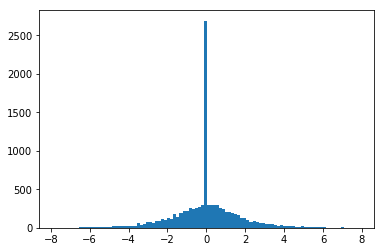

In [66]:
_= plt.hist(delta_mag, bins = 100)

In [70]:
len(np.where(delta_mag == 0)[0])

2422

In [60]:
len(delta_mag)

10000

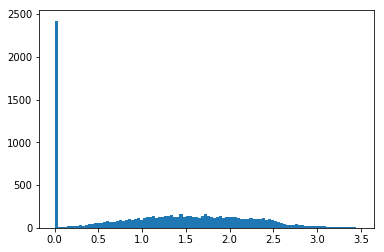

In [65]:
_= plt.hist(delta_r, bins = 100)

In [71]:
len(np.where(delta_r == 0)[0])

2422

In [72]:
def delta_min(shift_path, mag_path):
    mag =np.load(mag_path)
    shift =np.load(shift_path)
    
    #Reshape the list of shifts so that it is easily usable
    shifts = np.zeros((len(shift),3,2))
    mags = np.zeros((len(shift),4))

    for i in range (len(shift)):
        for j in range (len(shift[i])):
            shifts[i][j] = shift[i][j]
        for j in range (len(mag[i])):
            mags[i][j] = mag[i][j]

    # set lists
    deltas_r= np.zeros((len(shift),3))
    delta_r= np.zeros((len(shift)))

    deltas_mag= np.zeros((len(shift),3))
    delta_mag = np.zeros((len(shift)))

    # compute the delta r for each couple of galaxies
    for i in range (3):
        deltas_r[:,i] = np.sqrt(np.square(shifts[:,i,0])+np.square(shifts[:,i,1]))
        deltas_mag[:,i] = mags[:,i+1] - mags[:,0]

    # Take the min of the non zero delta r
    for j in range (len(shifts)):
        # If all the deta_r are equals to 0 (there is only on galaxy on the image) then write 0
        if (deltas_r[j,:].any() == 0):
            delta_r[j] = 0
            delta_mag[j] = 0
        else:
            x = np.where(deltas_r[j] == 0)[0]
            deltas = np.delete(deltas_r[j],x)
            delta_r[j] = np.min(deltas)
            y = np.where(deltas == np.min(deltas))[0]
            delta_mag[j] = deltas_mag[j,y]  
            
    return delta_r, delta_mag

# Batch generation

In [18]:
list_of_samples = ['/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_2_v5.npy']#/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_2_v4.npy

In [19]:
list_of_shifts = ['/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_shift_v5.npy']

In [20]:
bands = [4,5,6,7,8,9]

In [21]:
batch_gen = BatchGenerator_test(bands, list_of_samples,total_sample_size=10000, batch_size= 100, magnitude = mag, shift = shift, training_or_validation = 'validation', noisy = True)#_lsst_process

In [39]:
input_lsst = batch_gen.__getitem__(2)


In [20]:
len(input_lsst[4]), input_lsst[4].shape , input_lsst[4][0]

(100, (100,), 2.8321985073050793)

## LSST only

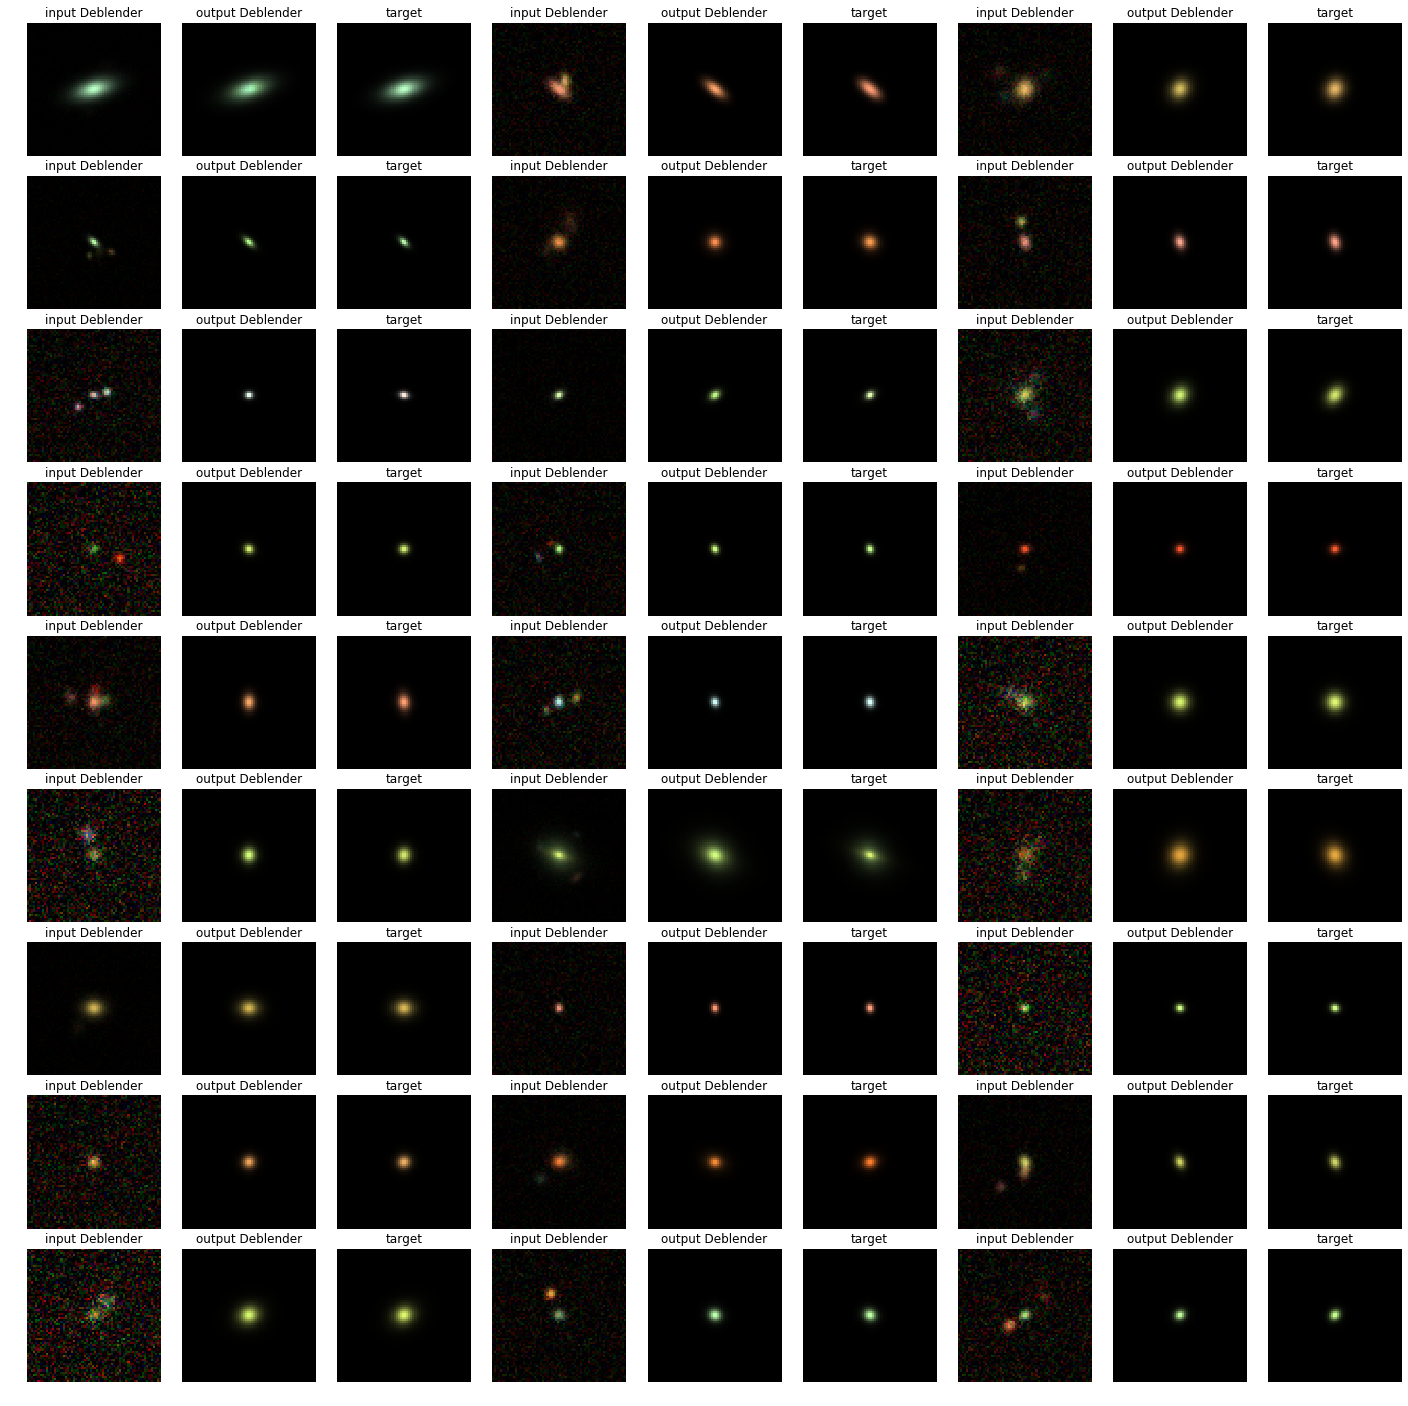

In [28]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

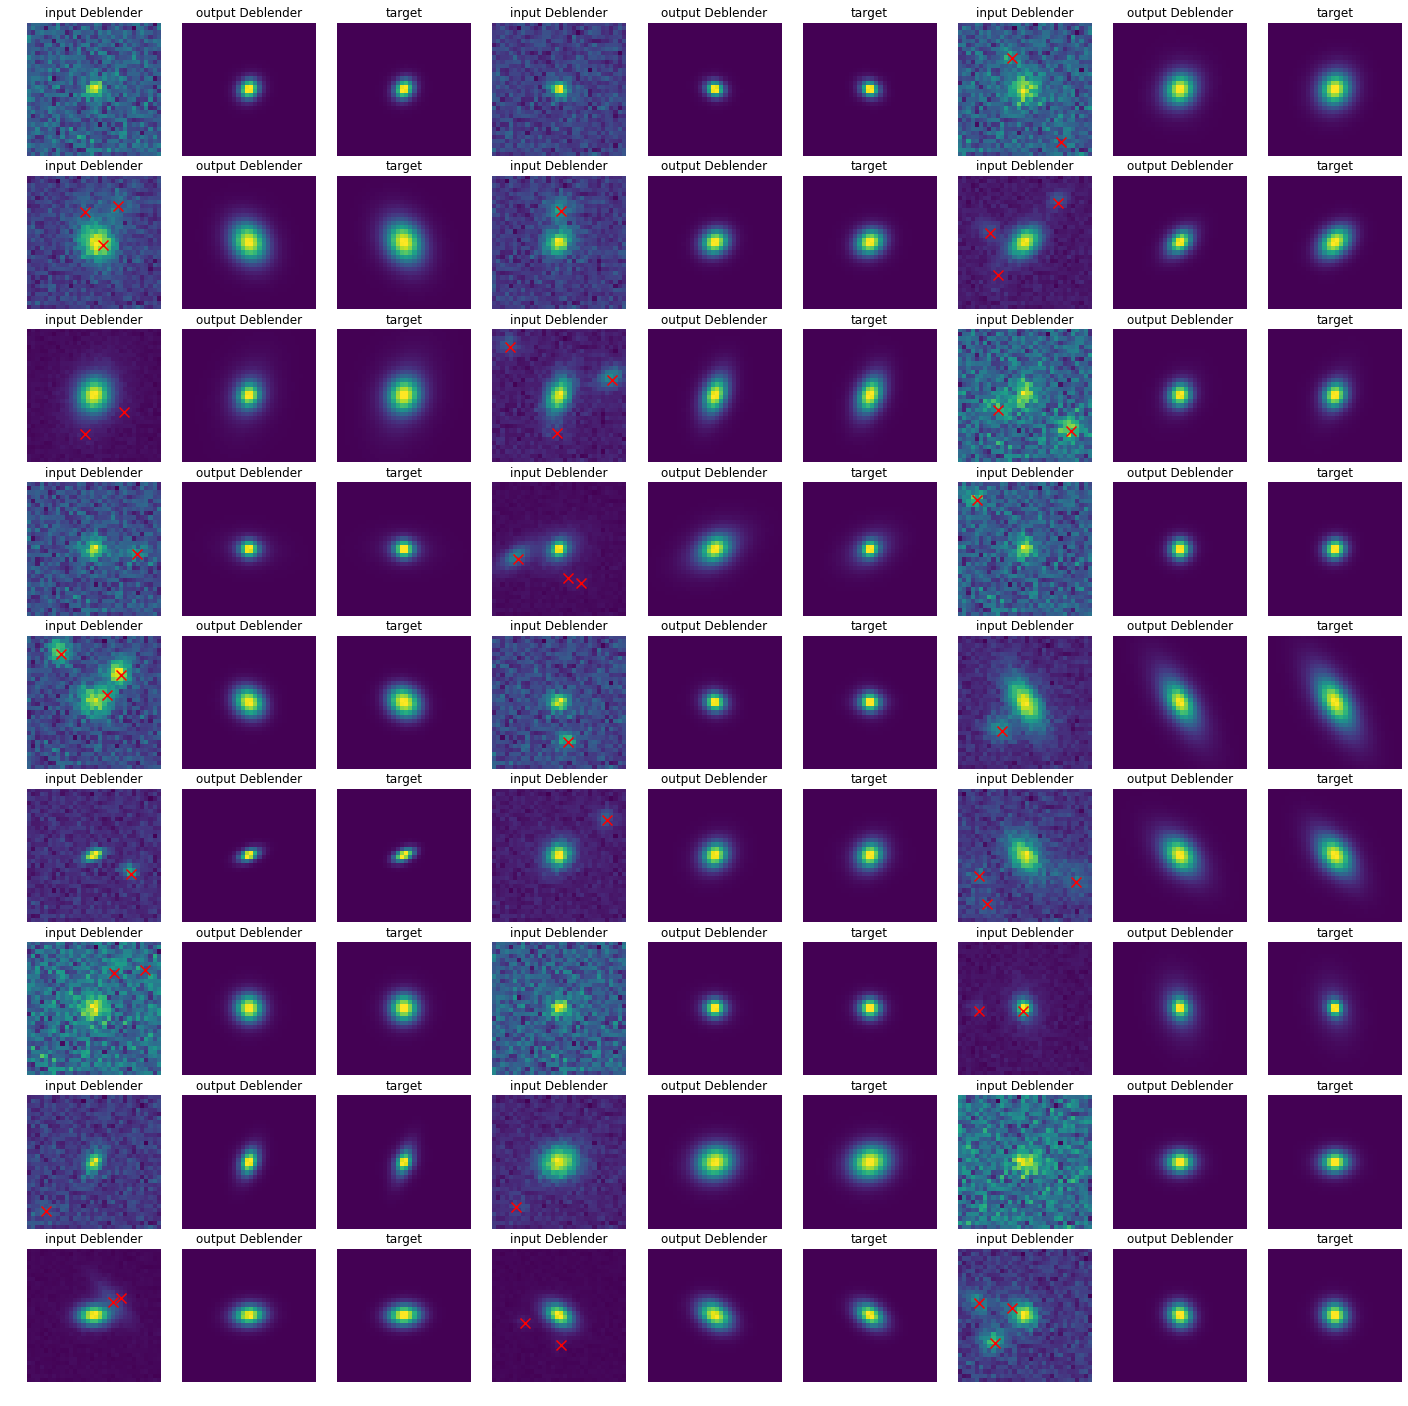

In [20]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

mag = input_lsst[2]
shift = input_lsst[3]

for i in range(N_plot):
    for j in range(0,N_plot,3):
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]][16:48,16:48,2])
        
        for k in range (len(shift[indices[i*N_plot+j]])):
            axes[i,j].scatter(16+shift[indices[i*N_plot+j]][k][0]/0.2, 16+shift[indices[i*N_plot+j]][k][1]/0.2,s = 100,c='red', marker='x')

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][16:48,16:48,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][16:48,16:48,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')
        
        

# Shape reproduction

In [ ]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []
magnitudes = []
deltas_r = []
deltas_m = []

for j in range(100):
    a = batch_gen.__getitem__(2)
    output_vae = deblender.predict(a[0], batch_size = batch_size)
    output_vae = denorm(output_vae, bands, channel_last = True)
    input_noiseless = denorm(a[1], bands, channel_last = True)

    for i in range (len(a[0])):#a[0] test
        try: 
            gal_image = galsim.Image(input_noiseless[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]

            gal_image = galsim.Image(output_vae[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]

            ellipticities.append([e_in, e_out])

            magnitudes.append(a[2])
            
        except :
            print('error for galaxy '+str(j*100+i))
            pass
        continue
          
    delta_r = a[4] 
    delta_mag = a[5]
    deltas_r.append(delta_r)
    deltas_m.append(delta_mag)

ellipticities_r_band = np.array(ellipticities)
magnitudes = np.array(magnitudes)
delta_r_arr = np.array(deltas_r)
delta_mag_arr = np.array(deltas_m)

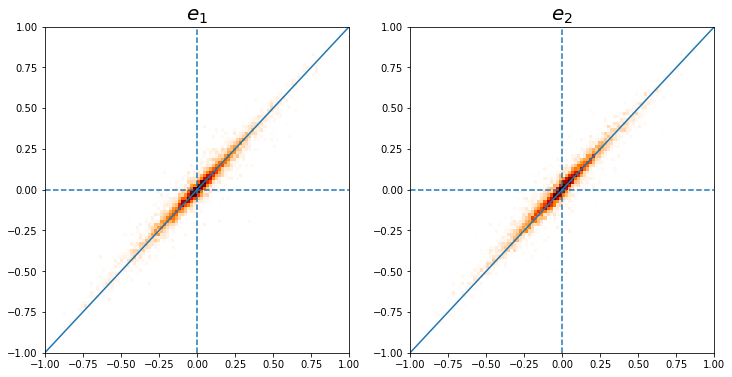

In [36]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    

In [37]:
import seaborn as sns

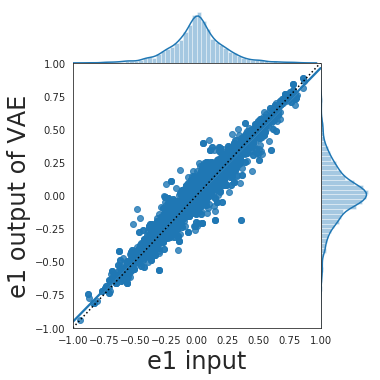

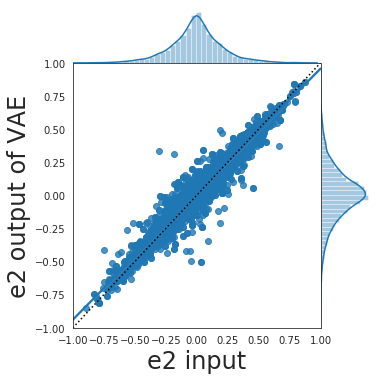

In [38]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

In [76]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

In [77]:
delta_mag_arr.shape

(100, 100)

In [85]:
test = np.where(delta_mag_arr ==0)
len(test[0])

7078

In [86]:
test = np.where(delta_r_arr ==0)
len(test[0])

2439

In [80]:
delta_mag_arr_test = np.concatenate(delta_mag_arr, axis = 0)

In [82]:
delta_mag_arr_test.shape

(10000,)

In [84]:
test = np.where(delta_mag_arr_test ==0)
len(test[0])

7078

In [89]:
delta_mag_arr = np.concatenate(delta_mag_arr, axis = 0)

In [90]:
delta_r_arr = np.concatenate(delta_r_arr, axis = 0)

In [91]:
delta_mag_arr.shape

(10000,)

In [92]:
test = np.where(delta_r_arr ==0)

In [93]:
test[0], test[0].shape

(array([   2,    6,   11, ..., 9993, 9998, 9999]), (2439,))

In [94]:
delta_test = np.delete(delta_e1, test[0], axis = 0)

In [95]:
delta_test.shape

(7561,)

In [96]:
delta_mag_test = np.delete(delta_mag_arr, test[0], axis = 0)
delta_r_test = np.delete(delta_r_arr, test[0], axis = 0)

In [97]:
delta_mag_test.shape, delta_r_test.shape

((7561,), (7561,))

(-10, 10)

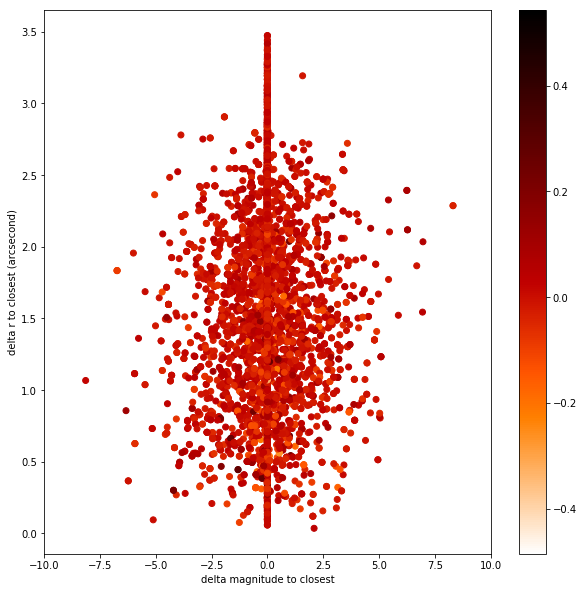

In [98]:
import matplotlib as mpl
fig, axes = plt.subplots(1, figsize=(10,10))

plt.scatter(delta_mag_test, delta_r_test,  c = delta_test, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
plt.xlabel("delta magnitude to closest")
plt.ylabel("delta r to closest (arcsecond)")
plt.colorbar()
#plt.xscale('log')
plt.xlim(-10,10)

In [17]:
batch_size = 100

In [18]:
a = batch_gen.__getitem__(2)
output_enc = encoder.predict(a[0], batch_size = batch_size)

In [19]:
latent_dim =32
epsilon_std = 1.0

In [20]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon


z = []
for i in range (100):
    a = batch_gen.__getitem__(2)
    output_enc = encoder.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))

In [21]:
z = np.concatenate(z, axis = 0)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


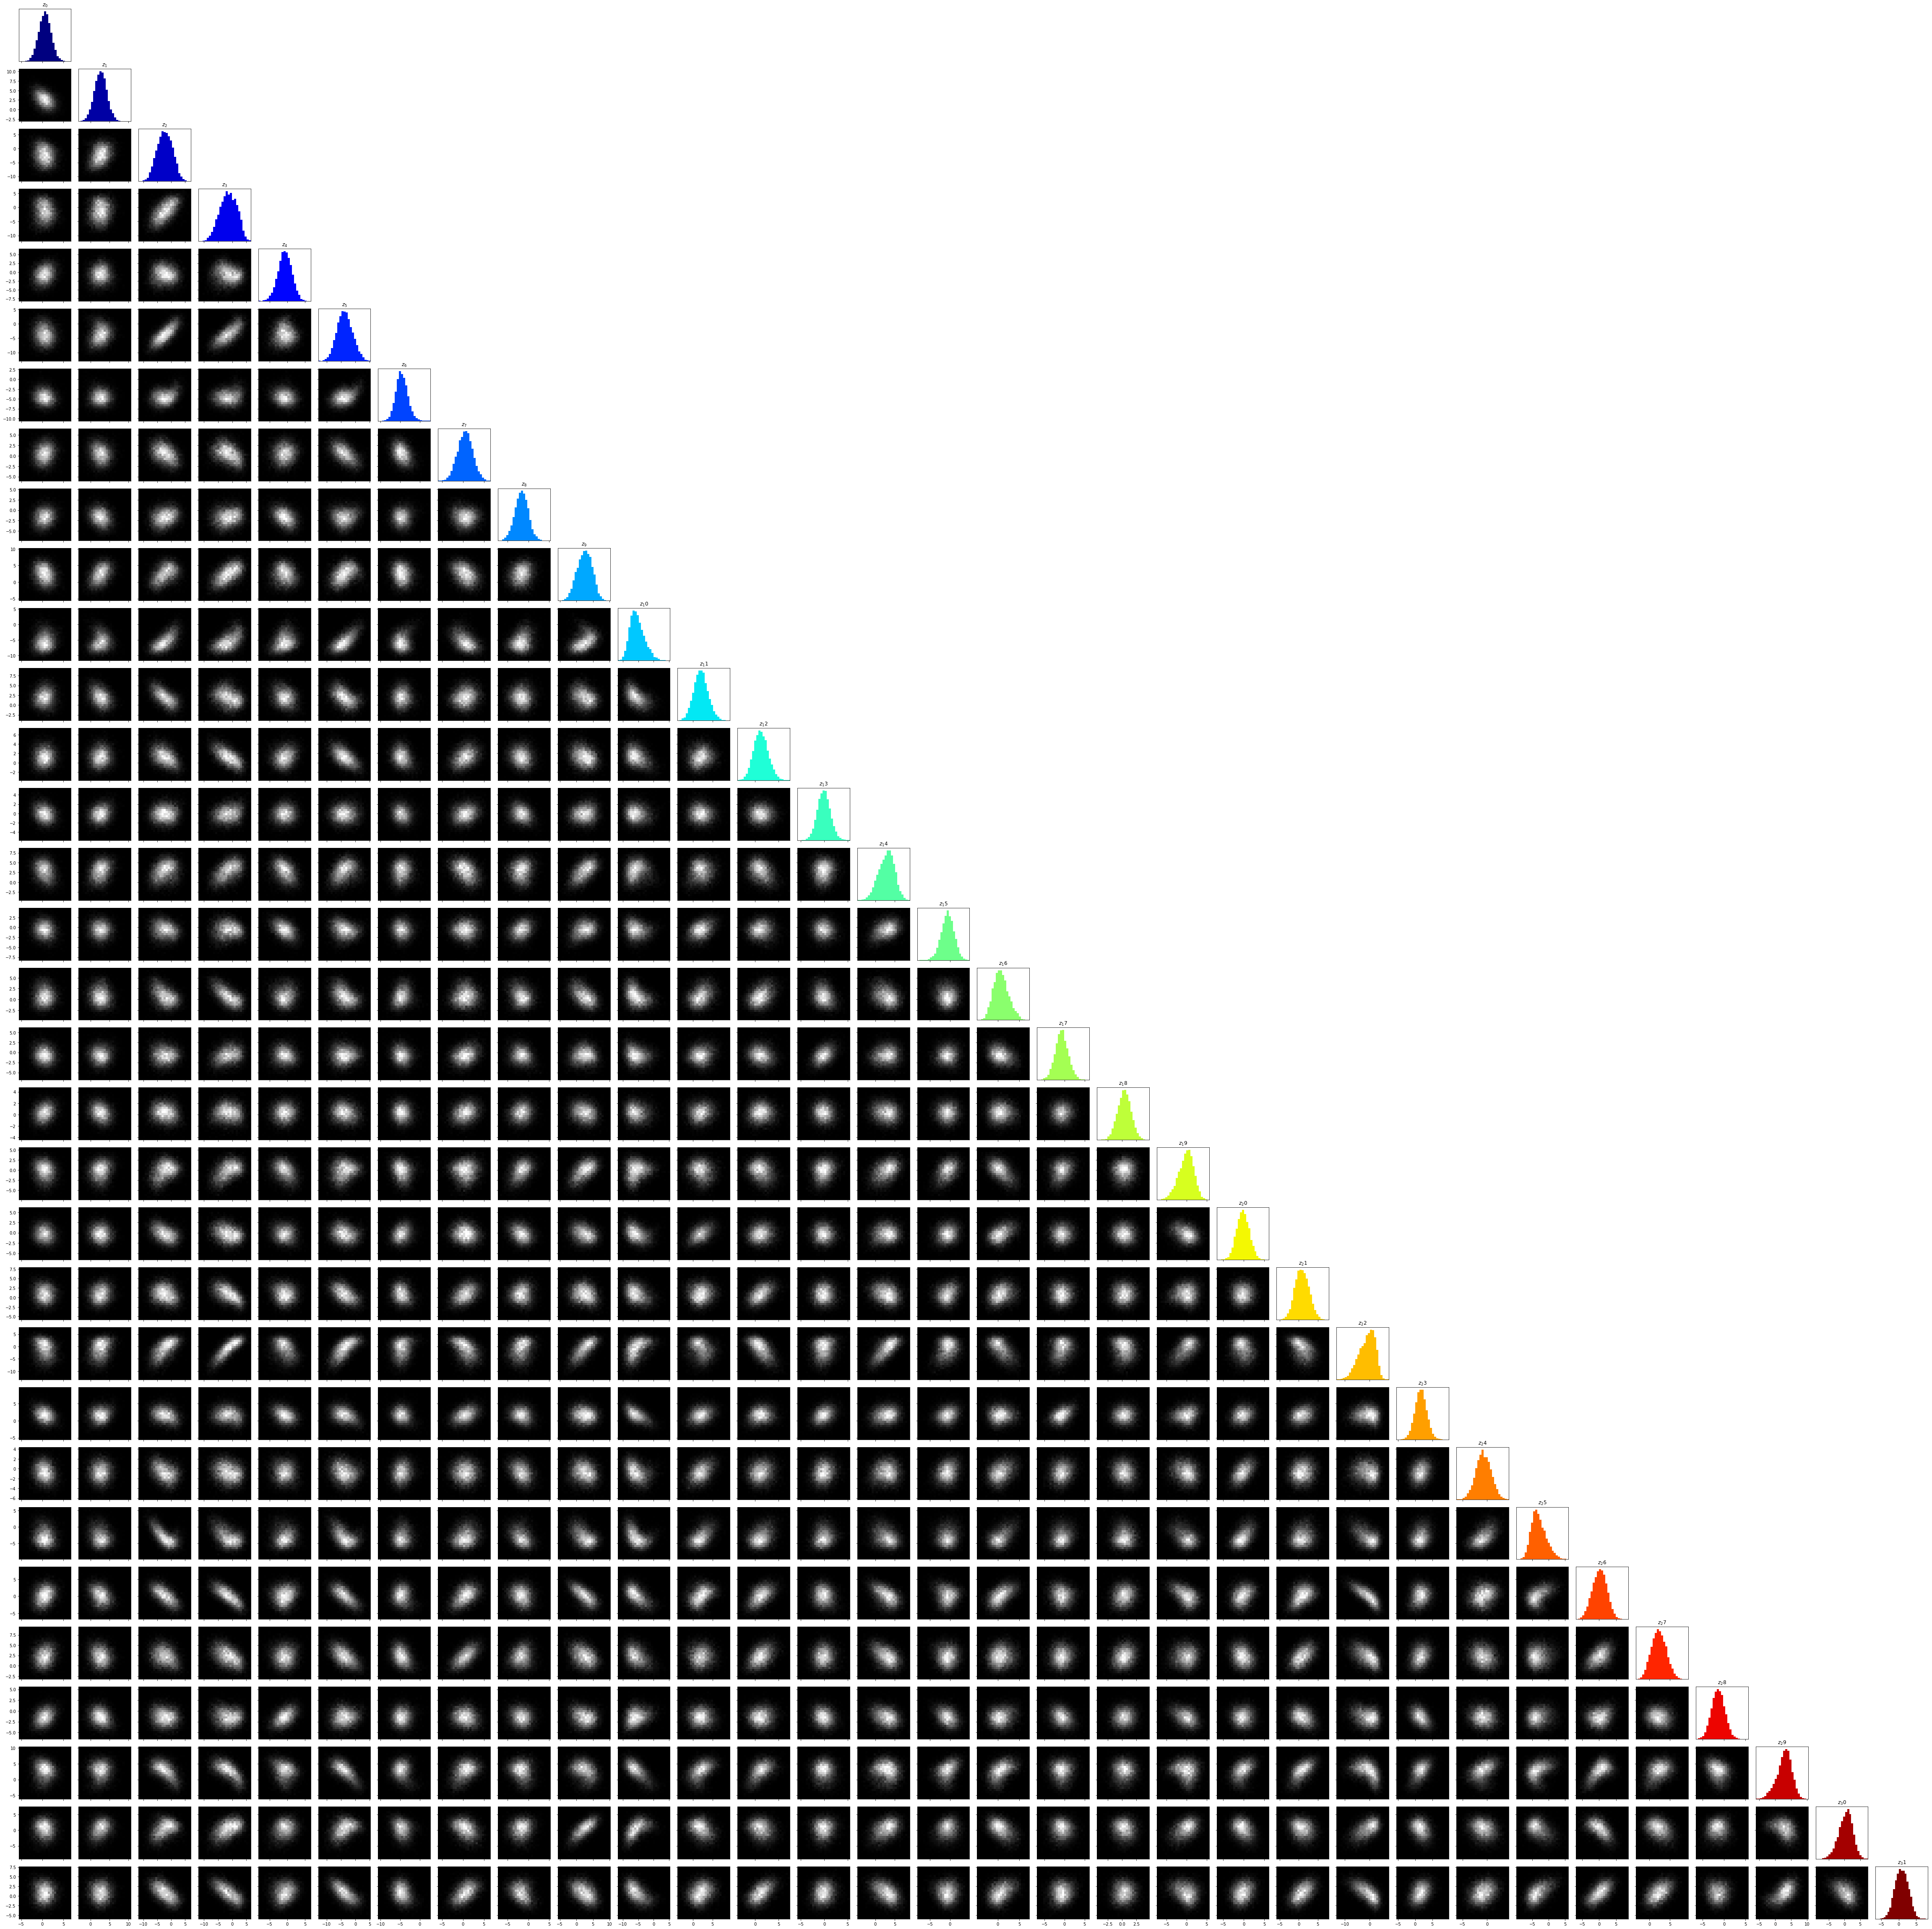

In [22]:
plot_corner_latent(z)

# Load the shifts to evaluate the distance between 2 galaxies

### Same analysis as function of delta r : all the images with only one galaxy are suppressed

In [14]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []
delta_r = []

for j in range(100):
    a = batch_gen.__getitem__(2)
    output_vae = deblender.predict(a[0].reshape((100,64,64,6)), batch_size = batch_size)#a[0] test[:,1,4:].reshape((10000,64,64,6))
    for i in range (len(a[0])):#a[0] test
        try: 
            if (a[2][i]!=0):
                gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])# 6, a[1][i] test[i,0,6]
                gal_image.scale = pix_scale

                res = galsim.hsm.EstimateShear(gal_image, psf_image)
                e_in = [res.corrected_e1, res.corrected_e2]

                gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
                gal_image.scale = pix_scale

                res = galsim.hsm.EstimateShear(gal_image, psf_image)
                e_out = [res.corrected_e1, res.corrected_e2]

                ellipticities.append([e_in, e_out])
                delta_r.append(a[2][i])
        except :
            print('error for galaxy '+str(j*100+i))
            pass
        continue

ellipticities_r_band = np.array(ellipticities)
delta_r_list = np.array(delta_r)

error for galaxy 851
error for galaxy 1145
error for galaxy 1919
error for galaxy 2022
error for galaxy 2785


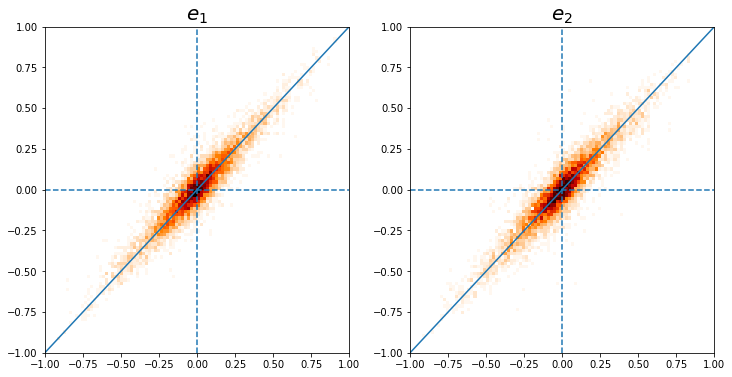

In [45]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [46]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

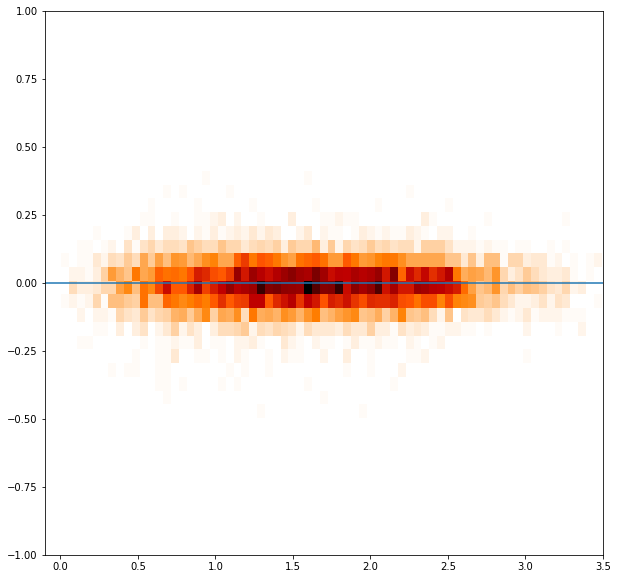

In [52]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e1, bins=np.linspace(-1,4,100), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

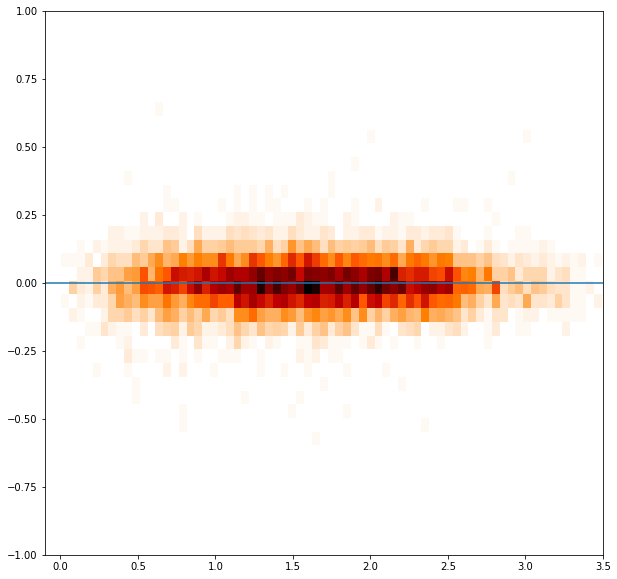

In [53]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e2, bins=np.linspace(-1,4,100), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

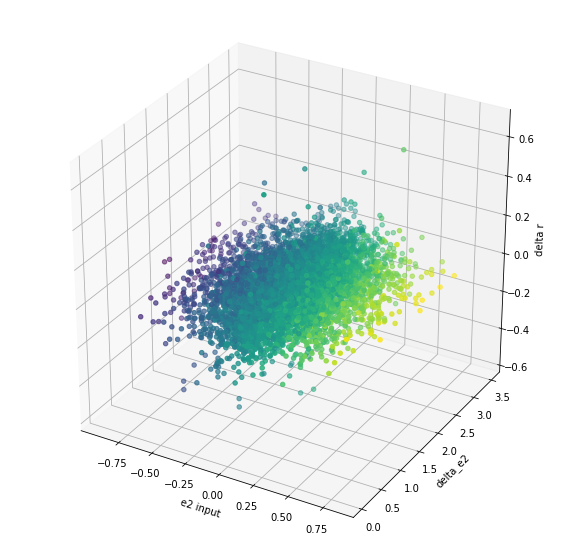

In [50]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

xs = ellipticities_r_band[:,0,1]
ys = delta_r
zs = delta_e2
ax.scatter(xs, ys, zs, c=xs, cmap='viridis')

ax.set_xlabel('e2 input')
ax.set_ylabel('delta_e2')
ax.set_zlabel('delta r')

plt.show()


### N sampling for the same galaxy on the 10 000 and take the mean

In [16]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

N_sampling = 100
N = 1

ellipticities_n = np.zeros((N_sampling, batch_size, 2,2 ))
ellipticities = []
delta_r = []
e = []


for j in range(N):
    a = batch_gen.__getitem__(2)
    for k in range (N_sampling):
        output_vae = deblender.predict(a[0].reshape((100,64,64,6)), batch_size = batch_size)

        for i in range (batch_size):
            if (a[2][i]!=0):
                try: 
                        gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_in = [res.corrected_e1, res.corrected_e2]
                        e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

                        gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_out = [res.corrected_e1, res.corrected_e2]
                        e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

                        ellipticities_n[k,i] = [e_in, e_out]
                        e.append([e_beta_in, e_beta_out])
                except :
                    print('error for galaxy '+str(j*100+i)+' sample '+str(k))
                    pass
                continue
                delta_r.append(a[2][i])
    print(np.array(ellipticities_n).shape)
    
    ellipticities.append(np.mean(np.array(ellipticities_n), axis = 0))
    print(np.array(ellipticities).shape)
        
        
ellipticities_r_band = np.array(ellipticities).reshape((100,2,2))
delta_r_list = np.array(delta_r)
e_beta = np.array(e)

(100, 100, 2, 2)
(1, 100, 2, 2)


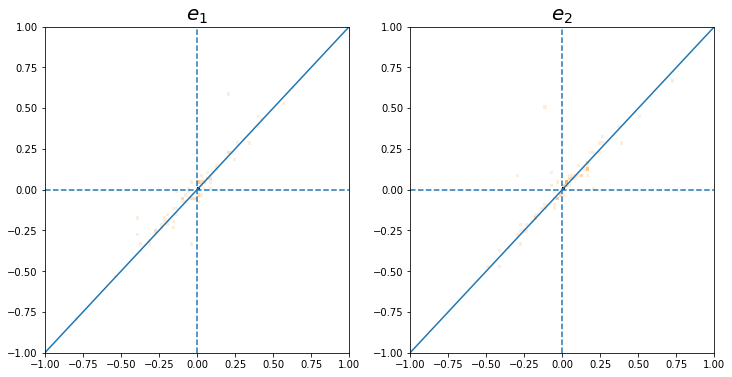

In [18]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [24]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

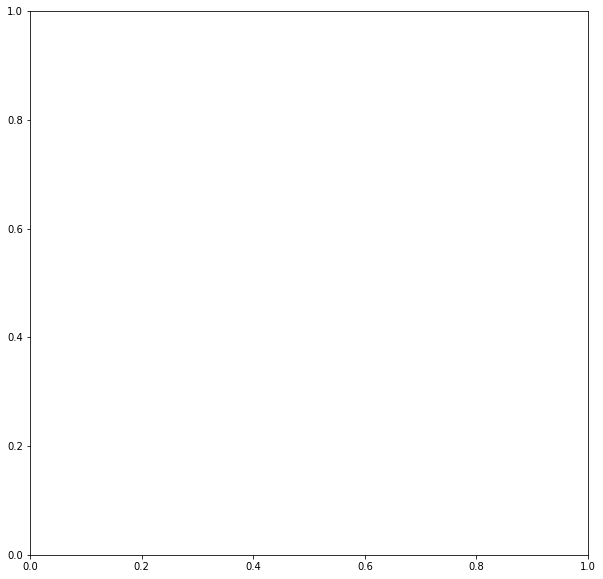

In [26]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e1, bins=np.linspace(-1,4,10), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

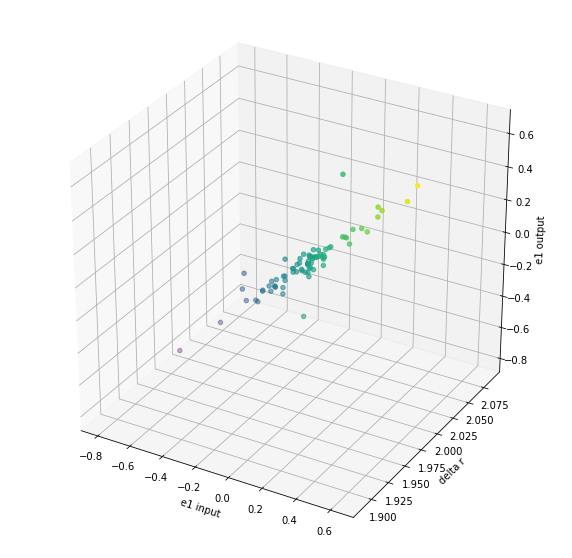

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

xs = ellipticities_r_band[:,0,0]
ys = delta_r
zs = ellipticities_r_band[:,1,0]
ax.scatter(xs, ys, zs, c=xs, cmap='viridis')

ax.set_xlabel('e1 input')
ax.set_ylabel('delta r')
ax.set_zlabel('e1 output')

plt.show()

In [ ]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [ ]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

In [ ]:
res_out_r_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')


gal = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    plt.imshow(list_galsim_simple[0][0].reshape((10,64,64))[6])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    try: 
        print(i)
        for j in range (nb_of_samplings):
            print(j)
            output_vae_list_r = vae_lsst_r_band_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,6], batch_size = batch_size)
            output_vae_list_r = output_vae_list_r.reshape((batch_size,64,64))

            output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,4:].reshape((batch_size,64,64,6)), batch_size = batch_size)
            output_vae_list_lsst = output_vae_list_lsst.reshape((batch_size,6,64,64))

            output_vae_list_lsst_euclid = vae_lsst_euclid_conv.predict(list_galsim_simple[0], batch_size = batch_size)
            output_vae_list_lsst_euclid = output_vae_list_lsst_euclid.reshape((batch_size,10,64,64))

            for t in range (batch_size):
                img_out_simple = galsim.Image(output_vae_list_r[t])
                res_out_r_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_r_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst[t,2])
                res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst_euclid[t,6])
                res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
#print(res_out[i,j*batch_size+t])

            
            
    except :
        err_count +=1
        print('erreur')
        pass
    continue
            
print(err_count)

In [ ]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(gal[k].reshape((10,64,64))[6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    print(res_in_e1[k], res_in_e2[k])

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(25,14))

ax = axes[0,0]
_ = ax.hist(res_out_r_e1[0],  bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[0], bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)
variance = np.var(res_out_r_e1[0])
sigma = np.sqrt(variance)
x = np.linspace(min(res_out_r_e1[0]), max(res_out_r_e1[0]), 100)
#ax.plot(x, mlab.normpdf(x, mean, sigma))


ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_r_e1[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_r_e1[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[2] , bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_r_e2[0] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[0] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_r_e2[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_r_e2[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[2] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

# Compare deblender LSST vs LSST+Euclid

In [41]:
def compare_deblender(deb1, deb2,nb_1, nb_2, input_deb_1, input_deb_2, expected):
    ######
    # deb1, deb2 : the 2 deblenders which are being compared
    # nb_1, nb_2 : number of bands in the images processed respectively by deb1 and deb2
    # input_deb_1, input_deb_2 : the noisy blended images to process respectively for deb1 and deb2
    # expected: the noiseless centered galaxy images which are the targerts for the deblender 1
    ######
    # List of noisy blended images
    list_blended_1 = input_deb_1.reshape(len(input_deb_1),64,64,nb_1)
    list_blended_2 = input_deb_2.reshape(len(input_deb_2),64,64,nb_2)
    print(list_blended_1.shape)
    # List of noiseless centered galaxy
    list_simple = expected
    
    # Use deblenders on list of blended images
    list_output_1 = deb1.predict(list_blended_1, batch_size= 100)
    list_output_2 = deb2.predict(list_blended_2, batch_size= 100)
    
    # Reshape the lists so that it can be used for measurement
    list_output_1 = list_output_1.reshape(len(input_deb_1),nb_1,64,64)
    list_output_2 = list_output_2.reshape(len(input_deb_2),nb_2,64,64)
    print(list_output_1.shape)
    list_simple = list_simple.reshape(len(expected),nb_1,64,64)

    # Create empty lists for the futur measurements
    g_in = np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g1_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g2_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    
    g_out_1 = np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g1_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g2_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')

    g_out_2 = np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g1_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g2_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')

    err_count = 0
    for i in range (100):#len(input_deb_1)):
#        try :
        #print('image : '+str(i))
        # Add a PSF to be able to do an estimation of the shear
        PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
        final_epsf_image = PSF.drawImage(scale=0.2)

        # Define the images
        img_in = galsim.Image(list_simple[i,nb_1-4,16:48,16:48])
        #print(list_blended_1.shape)
        img_out_1 = galsim.Image(list_output_1[i,nb_1-4,16:48,16:48])
        img_out_2 = galsim.Image(list_output_2[i,nb_2-4,16:48,16:48])
        #print(list_output_1[i,nb_1-4,16:48,16:48].shape, str(nb_1-4))
        #print(list_output_2[i,nb_2-4,16:48,16:48].shape, str(nb_2-4))
        #plt.imshow(list_output_1[i,nb_1-4])
        # Measurements 
        ## for the input image
        g_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g
        #print(g_in[i])
        g1_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g1
        #print(g1_in[i])
        g2_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g2
        #print(g2_in[i])
        
        ## for the output image for the deblender deb1
        g_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g
        #print(g_out_1[i])
        g1_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g1
        #print(g1_out_1[i])
        g2_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g2
        #print(g2_out_1[i])
        ## for the output image for the deblender deb2
        g_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g
        #print(g_out_2[i])
        g1_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g1
        #print(g1_out_2[i])
        g2_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g2
        #print(g2_out_2[i])
#        except :
#            err_count +=1
#            print('erreur')
#            pass
#        continue
#    print(err_count)
    
    return g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2

In [42]:
g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2 = compare_deblender(deblender_lsst, deblender_lsst_euclid,6,10,input_deblender_lsst, input_deblender_lsst_euclid, input_deblender_no_noise_lsst)

(10000, 64, 64, 6)
(10000, 6, 64, 64)
image : 0
0.2082479
0.19913106
-0.060942654
0.036790792
0.034009717
-0.014032165
0.16499282
0.15605693
-0.0535618
image : 1
0.16798127
-0.026451362
0.1658856
0.15658477
-0.03602771
0.15238371
0.17420697
-0.019408643
0.17312242
image : 2
0.015851352
-0.0019065625
-0.015736276
0.08868295
-0.021780383
-0.085966736
0.02348353
-0.021882499
-0.008522464
image : 3
0.021669954
0.014525538
0.016080908
0.020390408
0.020253738
-0.002356865
0.03144208
0.021906106
0.022554975
image : 4
0.20160483
-0.0011992565
0.20160127
0.20832688
0.00688239
0.20821317
0.18581249
0.011259531
0.18547103
image : 5
0.23158796
-0.104689494
0.20657468
0.23533344
-0.12658247
0.19839028
0.2287074
-0.10791111
0.20164888
image : 6
0.11998794
-0.117808565
-0.022765057
0.07408505
-0.010791827
-0.07329482
0.10861742
-0.10680394
-0.01976517
image : 7
0.049526952
-0.0055145873
-0.049218982
0.04815506
0.0016616306
-0.04812638
0.06094573
-0.003158866
-0.06086381
image : 8
0.04619206
-0.017668

-0.12442082
0.10392915
0.04133713
-0.095354654
image : 74
0.11875908
0.112435594
0.03823554
0.12378496
0.122179255
0.01987324
0.08360412
0.076007724
0.034820616
image : 75
0.20552595
-0.003458937
-0.20549685
0.20924947
-0.036455277
-0.20604938
0.18458277
0.0022645297
-0.18456888
image : 76
0.13287856
-0.12798539
0.03572745
0.13762611
-0.13466565
0.02839205
0.14154579
-0.13268964
0.049281526
image : 77
0.12189686
0.05458897
0.10899032
0.04391239
0.040948823
0.015858488
0.12846608
0.053195484
0.11693492
image : 78
0.07118125
0.06414389
0.03085987
0.05739784
0.054537885
0.017892204
0.057015285
0.044195596
0.036020715
image : 79
0.3680707
0.28004238
0.23885626
0.36813596
0.26644644
0.25402832
0.36800182
0.25942957
0.2610012
image : 80
0.1587331
-0.07762931
-0.13845536
0.19166158
-0.09155821
-0.16837832
0.16123722
-0.09631994
-0.1293055
image : 81
0.05116644
-0.035789974
-0.036566135
0.052614756
0.0011119178
-0.052603006
0.037910182
0.0035725504
-0.03774147
image : 82
0.12260909
-0.06430983

In [43]:
# Calculate the differences from output measurement compared to input
## LSST
delta_g_lsst = g_in - g_out_1
delta_g1_lsst = g1_in- g1_out_1
delta_g2_lsst = g2_in-g2_out_1

## LSST + Euclid
delta_g_lsst_euclid = g_in - g_out_2
delta_g1_lsst_euclid = g1_in- g1_out_2
delta_g2_lsst_euclid = g2_in-g2_out_2


The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


ValueError: weights should have the same shape as a.

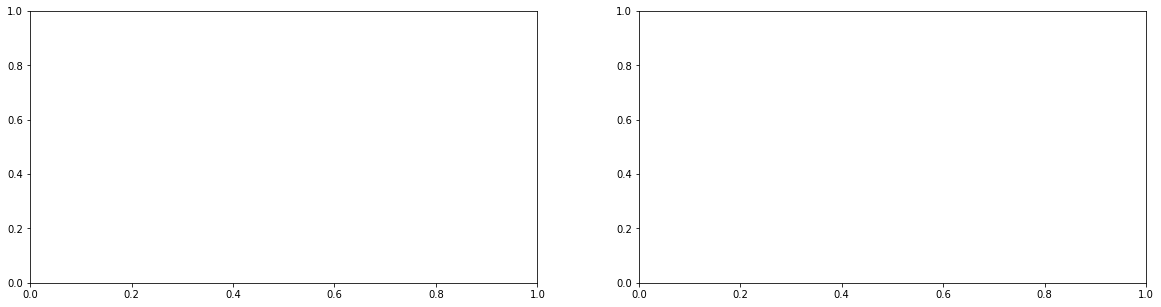

In [63]:
# Plot of the LSST and LSST+Euclid results comparison

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g, var_delta_g = mean_var(delta_r,delta_g_lsst_euclid,bins)
mean_delta_g1, var_delta_g1 = mean_var(delta_r,delta_g1_lsst_euclid,bins)
mean_delta_g2, var_delta_g2 = mean_var(delta_r,delta_g2_lsst_euclid,bins)

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r,delta_g2_lsst,bins)



ax = axes[0]
ax.plot(mid, mean_delta_g1, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g1 - 10*var_delta_g1**0.5, mean_delta_g1 + 10*var_delta_g1**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g2 - 10*var_delta_g2**0.5, mean_delta_g2 + 10*var_delta_g2**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

### Only the LSST results

In [ ]:
# Plot of the LSST results only

ig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r_2,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r_2,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r_2,delta_g2_lsst,bins)


#ax = axes[0]
#ax.plot(mid,mean_delta_g_lsst, label = 'LSST')
#ax.fill_between(mid, mean_delta_g_lsst - 10*var_delta_g_lsst**0.5, mean_delta_g_lsst + 10*var_delta_g_lsst**0.5, alpha=0.5)
#ax.set_ylabel('delta g', fontsize = 10)
#ax.set_xlabel('delta r', fontsize = 10)
#ax.legend(fontsize = 10)
#ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

ax = axes[0]
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)